# Proyecto 2: Análisis de mercado inmobiliario

### **Propósito y Scope**

Recientemente te has incorporado al equipo de Datos de una gran inmobiliaria. La primera tarea que te fue asignada fue ayudar a los tasadores/as a valuar las propiedades, ya que es un proceso difícil y, a veces, subjetivo. Para ello, se esperó que puedas crear un modelo de Machine Learning que, dadas ciertas características de la propiedad, prediga su precio de venta.

Ya has tenido una primera aproximación a este problema, pero ahora quieres estudiar si es posible mejorar su desempeño y obtener una visión más profunda del problema. Para ello, debes aplicar transformaciones de datos y entrenar algunos Modelos Avanzados. ¿Qué puedes aprender del problema que estás abordando mediante el estudio de tu propio modelo?

* Retoma el notebook desarrollado para el Sprint Project 1 y considera la devolución que recibiste de tu tech reviewer.
---

## Importación de librerías

In [1]:
# Librería para medir tiempos
from datetime import datetime

# Librerías para la importación de archivos
import pandas as pd
import numpy as np

# Liberías para el tratamiento de los datos
import feature_engine
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import RareLabelEncoder
import category_encoders as ce
from sklearn.base import BaseEstimator, TransformerMixin

# Librerías para gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

# Librerías para modelado
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import optuna
from optuna.samplers import TPESampler
import scipy as sp

import joblib
from tqdm.notebook import tqdm

# Librerías para interpretar modelo 
import shap
from sklearn.model_selection import learning_curve

In [2]:
# Tomamos el tiempo de inicio de ejecución
start_time = datetime.now()

In [3]:
WORK_WITH_SAMPLE = False # Línea que nos permite trabajar con una muestra de nuestros datos.

**¡Atención estimado evaluador!** Esta línea le permite optimizar su tiempo. A considerar, este es un cuaderno que tiene un tiempo estimado de duración de 2 horas y 24 minutos. Para poder verificar que ninguna línea arroja error sin tener que ocupar ese tiempo le recomiendo que simplemente reemplace el `False` de la celda anterior por un `True`. De esta manera podrá trabajar con una muestra parcial de los datos, ayudando a que el código “corra” mucho más rápido y termine antes su evaluación. ¡Ah! una sola cosa más, antes de hacerlo le pido por favor vea los resultados que trae el cuaderno con mi entrega simplemente para que coincidan con mi análisis. 

Muchas gracias

---
## Preprocesamiento de Datos

In [4]:
# Cargo el dataset original e imprimo las primeras 3 instancias.
df= pd.read_csv ('DS_Proyecto_01_Datos_Properati.csv')
df.head (3)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta


In [5]:
# Definimos con cuantos datos hacemos nuestra muestra. 
if WORK_WITH_SAMPLE:
    df = df.sample(n=10000, random_state=42)

In [6]:
# Imprimo cuántas filas y columnas tiene nuestro dataset.
print('Cantidad de filas y columnas:',df.shape)

Cantidad de filas y columnas: (146660, 19)


In [7]:
# Reviso si hay filas duplicadas.
duplicate_rows=df[df.duplicated ()] 
print ('Número de filas duplicadas:',duplicate_rows.shape)

Número de filas duplicadas: (2358, 19)


In [8]:
# Veo el total de filas por columna para luego poder verificar que se eliminan los duplicados correctamente.
df.count ()

start_date         146660
end_date           146660
created_on         146660
lat                136735
lon                136701
l1                 146660
l2                 146660
l3                 146660
rooms              146660
bedrooms           146660
bathrooms          140703
surface_total      126133
surface_covered    125046
price              146660
currency           146660
title              146660
description        146660
property_type      146660
operation_type     146660
dtype: int64

In [9]:
# Elimino las filas duplicadas y verifico cuantas filas nos quedan.
df = df.drop_duplicates ()
df.count ()

start_date         144302
end_date           144302
created_on         144302
lat                134730
lon                134696
l1                 144302
l2                 144302
l3                 144302
rooms              144302
bedrooms           144302
bathrooms          138378
surface_total      124041
surface_covered    122963
price              144302
currency           144302
title              144302
description        144302
property_type      144302
operation_type     144302
dtype: int64

In [10]:
# Veo los tipos datos para asegurarme que no haya valores númericos que esten cargados como cadena u objeto.
df.dtypes

start_date          object
end_date            object
created_on          object
lat                float64
lon                float64
l1                  object
l2                  object
l3                  object
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price              float64
currency            object
title               object
description         object
property_type       object
operation_type      object
dtype: object

In [11]:
# Elimino las columnas que no voy a utilizar (por no ser relevantes para nuestro análisis.)
df = df.drop (['created_on','currency','title','description', 
               'operation_type','start_date','end_date','l1'], axis =1)
df.head()

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,-34.605880,-58.384949,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,-34.624056,-58.412110,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,-34.593569,-58.427474,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,-34.581294,-58.436754,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
4,-34.914194,-57.938219,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH


In [12]:
# Renombro las columnas. 
df.rename (columns = {"lat":"Latitud", 'lon': 'Longitud','l2': 'Localidad', 
                                   'l3':'Barrio','rooms':'Ambientes','bedrooms':'Dormitorios', 
                                   'bathrooms':'Baños', 'surface_total':'Superficie_total', 
                                   'surface_covered':'Superficie_cubierta','price':'Precio', 
                                   'property_type':'Tipo_de_propiedad'}, inplace = True)
df.columns

Index(['Latitud', 'Longitud', 'Localidad', 'Barrio', 'Ambientes',
       'Dormitorios', 'Baños', 'Superficie_total', 'Superficie_cubierta',
       'Precio', 'Tipo_de_propiedad'],
      dtype='object')

### **"Missing"** 
**Valores Faltantes:** imprimo en pantalla los nombres de las columnas y cuántos valores faltantes hay por columna.

In [13]:
# Primero verifico cuales son las columnas a las que le faltan datos.
df.isnull().any()

Latitud                 True
Longitud                True
Localidad              False
Barrio                 False
Ambientes              False
Dormitorios            False
Baños                   True
Superficie_total        True
Superficie_cubierta     True
Precio                 False
Tipo_de_propiedad      False
dtype: bool

In [14]:
# Imprimo cuantos nulos tengo en cada columna.
print ('Valores faltantes por columna:')
print ('-------------------------------')

count=df['Longitud'].isnull().sum()
print('Longitud:',count)

count1=df['Latitud'].isnull().sum()
print('Latitud:',count1)

count2=df['Baños'].isnull().sum()
print('Baños:',count2)

count3=df['Superficie_total'].isnull().sum()
print('Superficie total:',count3)

count4=df['Superficie_cubierta'].isnull().sum()
print('Superficie cubierta:',count4)

Valores faltantes por columna:
-------------------------------
Longitud: 9606
Latitud: 9572
Baños: 5924
Superficie total: 20261
Superficie cubierta: 21339


**Una vez identificados los valores perdidos vamos a trabajar para recuperarlos.** 
* **1. Longitud:** Para esta imputación vamos a tomar la mediana de la Longitud agrupado por `Ciudad`. De esta manera, hace sentido recuperar esos datos. **¿Por qué?** El resultado es una Longitud "real" y corresponde al Barrio correcto pudiendo usar ese dato como uno "original" sin problema.

In [15]:
# Agrupamos por la columna Ciudad y calculamos la mediana sobre los datos de entrenamiento.
df_agrupado_lon = df.groupby('Barrio').agg({'Longitud' : 'median'})
df_agrupado_lon

,Longitud
Barrio,
Abasto,-58.410998
Agronomía,-58.491294
Almagro,-58.421491
Almirante Brown,-58.388921
Avellaneda,-58.347629
...,...
Villa Riachuelo,-58.471676
Villa Santa Rita,-58.481099
Villa Soldati,-58.442979


In [16]:
# Convertimos en un diccionario la agrupación.
mydict = dict(zip(df_agrupado_lon.index, df_agrupado_lon.Longitud))
df_lon= df.Barrio.map(mydict)

In [17]:
# Reemplazamos los valores NaN por nuestro diccionario con el método fillna...
df['Longitud'].fillna(inplace=True, value=df_lon)

In [18]:
# Verifico que la imputación se realizó de manera exitosa.
df['Longitud'] .isnull().any()

False

**¡Excelente!** Logramos recuperar los datos de Longitud. Continuemos con el siguiente atributo.
* **2. Latitud:** Repetimos los mismos pasos que realizamos para la Longitud. Agrupamos por `Cuidad`, calculamos la mediana e imputamos estos valores. **Importante:** Decidimos tomar el cálculo de la mediana para que los outlier no sesguen nuestra imputación.

In [19]:
# Agrupamos por la columna Ciudad y calculamos la mediana de la Latitud en nuestro datos de entrenamiento.
df_agrupado_lat = df.groupby('Barrio').agg({'Latitud' : 'median'})
df_agrupado_lat

,Latitud
Barrio,
Abasto,-34.603890
Agronomía,-34.592562
Almagro,-34.604695
Almirante Brown,-34.802811
Avellaneda,-34.681927
...,...
Villa Riachuelo,-34.691040
Villa Santa Rita,-34.614324
Villa Soldati,-34.662378


In [20]:
# Convertimos en un diccionario la agrupación.
mydict = dict(zip(df_agrupado_lat.index, df_agrupado_lat.Latitud))
df_lat= df.Barrio.map(mydict)

In [21]:
# Reemplazamos los valores NaN por nuestro diccionario con el método fillna...
df['Latitud'].fillna(inplace=True, value=df_lat)

In [22]:
# Verifico que la imputación se realizó de manera exitosa.
df['Latitud'] .isnull().any()

False

**¡Perfecto!** Ya tenemos tanto la Longitud como la Latitud completa en nuestro Dataframe. Continuamos.
* **3. Baños:** Para esta variable la imputación es más sencilla. Obtenemos el promedio del atributo y lo reemplazamos por los valores perdidos.

In [23]:
# Calculamos el promedio.
df['Baños'].mean()

1.5991776149387908

In [24]:
# Reemplazamos los NaN con el metodo fillna (redondeamos nuestro promedio en 2 porque no puede haber 1.6 baños).
df['Baños']=df[['Baños']].fillna(2)

In [25]:
# Validamos...
df['Baños'] .isnull().any()

False

**¡Estupendo!** Solo nos falta recuperar los valores para la Superficie.
* **4. Superficie Total:** Antes de definir el método para reemplazar los nulos en las `Superficies` revisamos las correlaciones de la variables para observar si nos podemos orientar como conviene recuperar nuestros datos.

In [26]:
# Determino las variables que me interesan correlacionar.
correlacion = df[['Ambientes','Dormitorios','Baños','Superficie_total',
                  'Superficie_cubierta', 'Precio']].corr()

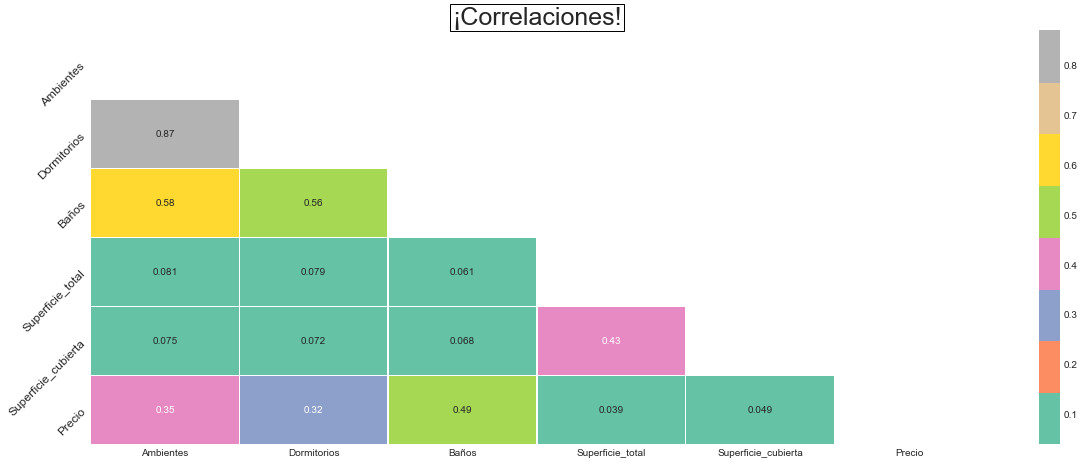

In [27]:
# Ahora si, realizo un mapa de calor para ver la correlación.
plt.rcParams['figure.figsize'] =(20, 10)
plt.style.use('seaborn-white')
matrix=np.triu(correlacion)
ax = sns.heatmap(correlacion,cmap='Set2', annot = True, linewidths=.5,mask=matrix)
plt.subplots_adjust(top=0.7)
ax.set_title ('¡Correlaciones!',fontsize=25,bbox={'facecolor':'1','pad':2})
plt.tick_params(axis='y', labelrotation=45, labelsize =12)
plt.show()

**No existe una correlación lo suficientemente fuerte que nos condicione como recuperar los valores de las Superficies.**

In [28]:
# Calculamos la media para la Superficie Total.
df['Superficie_total'].mean()

218.82341322627195

In [29]:
# Reemplazamos los NaN con el metodo fillna.
df['Superficie_total']=df[['Superficie_total']].fillna(218.82)

In [30]:
# Chequeamos..
df['Superficie_total'] .isnull().any()

False

**¡Impecable!** Ya casi terminamos, solo resta la Superficie cubierta
* **5.Superficie Cubierta:** Como hicimos con la variable `Baños` y `Superficie total`, calculamos la mediana e imputamos ese valor.

In [31]:
# Calculamos la mediana para la Superficie Cubierta.
df['Superficie_cubierta'].mean()

113.37929295804429

In [32]:
# Reemplazamos los NaN con el metodo fillna.
df['Superficie_cubierta']=df[['Superficie_cubierta']].fillna(113.37)

In [33]:
# Chequeamos..
df['Superficie_cubierta'] .isnull().any()

False

**¡Terminamos la imputación de los missing!**
* Imprimo los estadísticos de nuestros datos de entrenamiento para tener una primer idea de como quedaron los valores terminado el proceso de recupración de missing.

In [34]:
df.describe()

,Latitud,Longitud,Ambientes,Dormitorios,Baños,Superficie_total,Superficie_cubierta,Precio
count,144302.000000,144302.000000,144302.000000,144302.000000,144302.000000,144302.000000,144302.000000,1.443020e+05
mean,-34.602799,-58.468110,3.083540,1.984997,1.615632,218.822934,113.377919,2.406946e+05
std,0.457119,0.475089,1.420667,1.154110,0.874579,1904.924916,853.454794,3.171541e+05
min,-35.318457,-180.000000,1.000000,0.000000,1.000000,10.000000,1.000000,5.500000e+03
25%,-34.627334,-58.509097,2.000000,1.000000,1.000000,56.000000,50.000000,1.100000e+05
50%,-34.600137,-58.443941,3.000000,2.000000,1.000000,91.000000,78.000000,1.650000e+05
75%,-34.572271,-58.407373,4.000000,3.000000,2.000000,218.820000,113.370000,2.650000e+05
max,85.051129,-57.805832,35.000000,15.000000,14.000000,193549.000000,126062.000000,3.243423e+07


#### Primeras conclusiones: 

* La cantidad máxima de 35 ambientes posiblemente sea un outlier.
* La cantidad máxima de 14 baños posiblemente corresponda a un outlier.
* La cantidad máxima de 15 dormitorios posiblemente sea un outlier.
* Que el mínimo de dormitorios sea igual a 0 indica la posibilidad de que existan Mono ambientes.
* La superficie total de 193549 es seguramente un outlier.  
* La superficie cubierta de 126062 es muy probable que sea un outlier.
---
### **"Outliers"** 

In [35]:
# Reviso los atributos que posiblemente correspondan a los outliers desde nuestros datos de entrenamiento.
df['Ambientes'].value_counts().sort_index()

1.0     12945
2.0     40423
3.0     44240
4.0     28817
5.0     10489
6.0      4127
7.0      1822
8.0       805
9.0       235
10.0      223
11.0       46
12.0       53
13.0       13
14.0       12
15.0       18
16.0       12
18.0        5
20.0        7
21.0        2
24.0        1
25.0        2
26.0        2
30.0        1
32.0        1
35.0        1
Name: Ambientes, dtype: int64

**Los valores de Ambientes superiores o igual a 8 son poco representativos.**

In [36]:
df['Baños'].value_counts().sort_index()

1.0     81714
2.0     44248
3.0     12835
4.0      3902
5.0      1129
6.0       311
7.0       107
8.0        17
9.0        10
10.0       12
11.0        8
12.0        1
13.0        2
14.0        6
Name: Baños, dtype: int64

**Los valores de Baños superiores o igual a 6 son poco representativos.**

In [37]:
df['Dormitorios'].value_counts().sort_index()

0.0      7106
1.0     48705
2.0     45319
3.0     30945
4.0      8972
5.0      2059
6.0       768
7.0       258
8.0        65
9.0        32
10.0       23
11.0       14
12.0       16
13.0        6
14.0        8
15.0        6
Name: Dormitorios, dtype: int64

**Los valores de Dormitorios superiores o igual a 6 son poco representativos.**

In [38]:
df_monoamb=df[(df['Dormitorios'] == 0) & (df['Ambientes'] == 1)]
df_monoamb.sample(5)

,Latitud,Longitud,Localidad,Barrio,Ambientes,Dormitorios,Baños,Superficie_total,Superficie_cubierta,Precio,Tipo_de_propiedad
115280,-34.603587,-58.460766,Capital Federal,Paternal,1.0,0.0,1.0,218.82,113.37,88000.0,Departamento
92327,-34.593672,-58.442525,Capital Federal,Villa Crespo,1.0,0.0,1.0,29.00,29.00,75000.0,Departamento
11305,-34.589827,-58.423468,Capital Federal,Palermo,1.0,0.0,1.0,218.82,113.37,125000.0,Departamento
98194,-34.753725,-58.392134,Bs.As. G.B.A. Zona Sur,Lomas de Zamora,1.0,0.0,2.0,218.82,113.37,270000.0,Lote
58197,-34.775994,-58.389505,Bs.As. G.B.A. Zona Sur,Lomas de Zamora,1.0,0.0,2.0,218.82,113.37,98000.0,Departamento


**Los valores de dormitorios igual a 0 y ambientes igual a 1 indican mono ambientes.**

In [39]:
# Realizo un filtro excluyendo los valores que no son representativos de las variables analizadas.
df = pd.DataFrame (df[(df.Ambientes <= 8) & (df.Baños <= 6)& (df.Dormitorios<= 6)])

* Antes de avanzar con el análisis de las Superficies quiero ver la distribución del Dataset por Tipo de Propiedad, entendiendo que no podemos analizar de igual manera un Lote que un PH, por ejemplo.

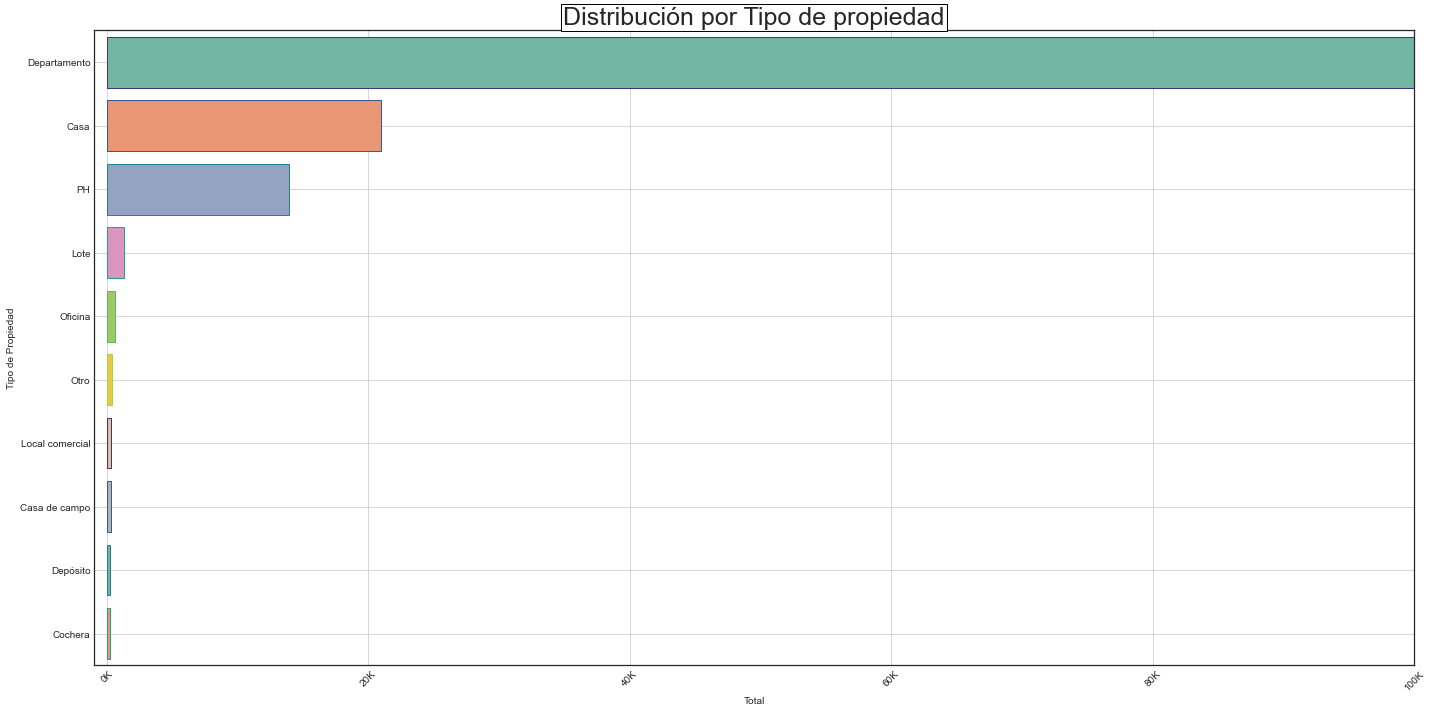

In [40]:
# Grafico la distribución por Tipo de propiedad.
ax =sns.countplot(data = df, y= 'Tipo_de_propiedad',edgecolor=sns.color_palette('viridis'),palette='Set2',
              order = df['Tipo_de_propiedad'].value_counts().index)
ax.set(xlim=[-1000, 100000], xlabel='Total', ylabel='Tipo de Propiedad')
plt.tick_params(axis='x', labelrotation=45)
plt.title('Distribución por Tipo de propiedad',fontsize=25,
          bbox={'facecolor':'1','pad':2})
# Defino una función que me permita abreviar los ceros de los miles o millones con una letra
def abbreviate(x, pos):
    if x >= 1e6:
        s = '{:1.1f}M'.format(x*1e-6)
    else:
        s = '{:1.0f}K'.format(x*1e-3)
    return s
ax.xaxis.set_major_formatter(abbreviate)

plt.tight_layout()
plt.grid()
plt.show ()

**¡Atención!** Podemos observar claramente la muestra esta desbalanceada en tres tipos de Propiedades: Departamento, Casa y PH. Decido quedarme con estos tres para continuar con nuestro trabajo.

In [41]:
# Realizo un filtro delimitando el tipo de propiedad de todo el dataframe.

# ¡SPOILER ALERT! A los efectos de poder comparar los modelos más adelante nos quedamos solo con los datos de Capital Federal.
# (al igual que en el spint 1).
df= (df[df.Tipo_de_propiedad.isin(['Departamento', 'PH', 'Casa']) 
                                   & (df.Localidad =='Capital Federal')])
df

,Latitud,Longitud,Localidad,Barrio,Ambientes,Dormitorios,Baños,Superficie_total,Superficie_cubierta,Precio,Tipo_de_propiedad
1,-34.624056,-58.412110,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,-34.593569,-58.427474,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,-34.581294,-58.436754,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
5,-34.593779,-58.441239,Capital Federal,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH
6,-34.600988,-58.433061,Capital Federal,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,PH
...,...,...,...,...,...,...,...,...,...,...,...
146554,-34.585355,-58.427194,Capital Federal,Palermo,4.0,3.0,3.0,175.0,111.0,570000.0,PH
146555,-34.585355,-58.427194,Capital Federal,Palermo,3.0,2.0,2.0,144.0,134.0,480000.0,PH
146556,-34.584134,-58.436389,Capital Federal,Palermo,4.0,2.0,2.0,317.0,143.0,530000.0,PH
146557,-34.583995,-58.417645,Capital Federal,Palermo,3.0,2.0,2.0,145.0,145.0,420000.0,Departamento


Ahora si, veamos como estan las Superficies.

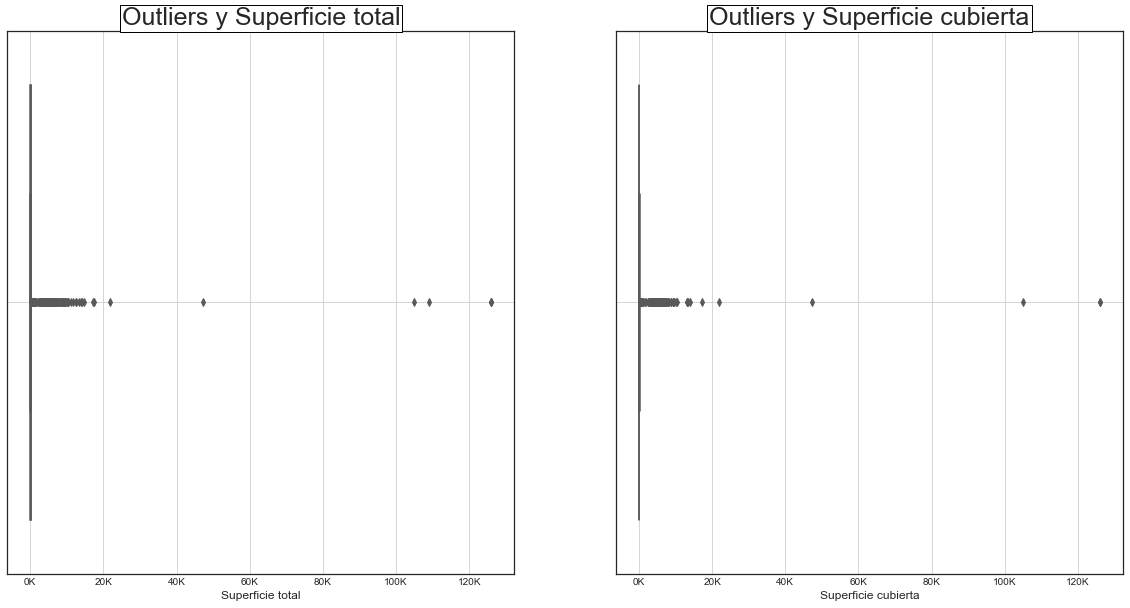

In [42]:
# Realizo un boxplot rápido para ver como es la distribución de la Superficie total y cubierta.

plt.subplot(1,2,1)
ax=sns.boxplot(data=df,x='Superficie_total',palette='Set2')
plt.grid()

ax.xaxis.set_major_formatter(abbreviate)
plt.xlabel('Superficie total', fontsize=12)
ax.set_title('Outliers y Superficie total',fontsize=25,bbox={'facecolor':'1','pad':2})

plt.subplot(1,2,2)
ax=sns.boxplot(data=df,x='Superficie_cubierta',palette='Set2')
plt.grid()
ax.xaxis.set_major_formatter(abbreviate)
ax.set_title('Outliers y Superficie cubierta',fontsize=25,bbox={'facecolor':'1','pad':2})
plt.xlabel('Superficie cubierta', fontsize=12)

plt.show()

 **De acuerdo al grafico estimo, que tanto en la Superficie total como en la Superficie cubierta los valores superiores a 20.000 seguramente sean outliers.**
 
Para resolver este problema y no guiarnos por nuestra estimación al observar y eliminar correctamente los valores extremadamente alejados decidí aplica el rango intercuartílico IQR.
* Primero lo realizo sobre las Superficies. Utilizo el cuantil 0.01 para evitar tener valores negativos en la superficie mínima.

In [43]:
unicos = df['Tipo_de_propiedad'].unique()
for x in unicos:
    Q1 = df[df['Tipo_de_propiedad']==x]['Superficie_total'].quantile(0.25)
    Q3 = df[df['Tipo_de_propiedad']==x]['Superficie_total'].quantile(0.75)
    IQR = Q3 - Q1
    surface_min = df[df['Tipo_de_propiedad']==x]['Superficie_total'].quantile(0.01) 
    surface_max = Q3 + (IQR*1.5)
    print(x)
    print('La Superficie maxima es {} y la superficie minima es {} y el IQR {}' .format(surface_max,surface_min,IQR))
    print('------------------------------------------------------------------------------')

PH
La Superficie maxima es 270.0 y la superficie minima es 35.0 y el IQR 80.0
------------------------------------------------------------------------------
Departamento
La Superficie maxima es 239.0 y la superficie minima es 26.0 y el IQR 76.0
------------------------------------------------------------------------------
Casa
La Superficie maxima es 492.0 y la superficie minima es 56.0 y el IQR 128.0
------------------------------------------------------------------------------


In [44]:
# Divido el dataset por tipo de propiedad para graficar su distribución sin los outlier
df_dpto=df[df['Tipo_de_propiedad']=='Departamento'] 
df_ph=df[df['Tipo_de_propiedad']=='PH']
df_casa=df[df['Tipo_de_propiedad']=='Casa'] 

In [45]:
# Filtro los subgrupos de nuestro dataset excluyendo los outliers.
df_ph=df_ph[(df_ph.Superficie_total<=270.0)&(df_ph.Superficie_total>=35.0)]
df_dpto=df_dpto[(df_dpto.Superficie_total<=239.0)&(df_dpto.Superficie_total>=26.0)]
df_casa=df_casa[(df_casa.Superficie_total<=492.0)&(df_casa.Superficie_total>=56.0)]

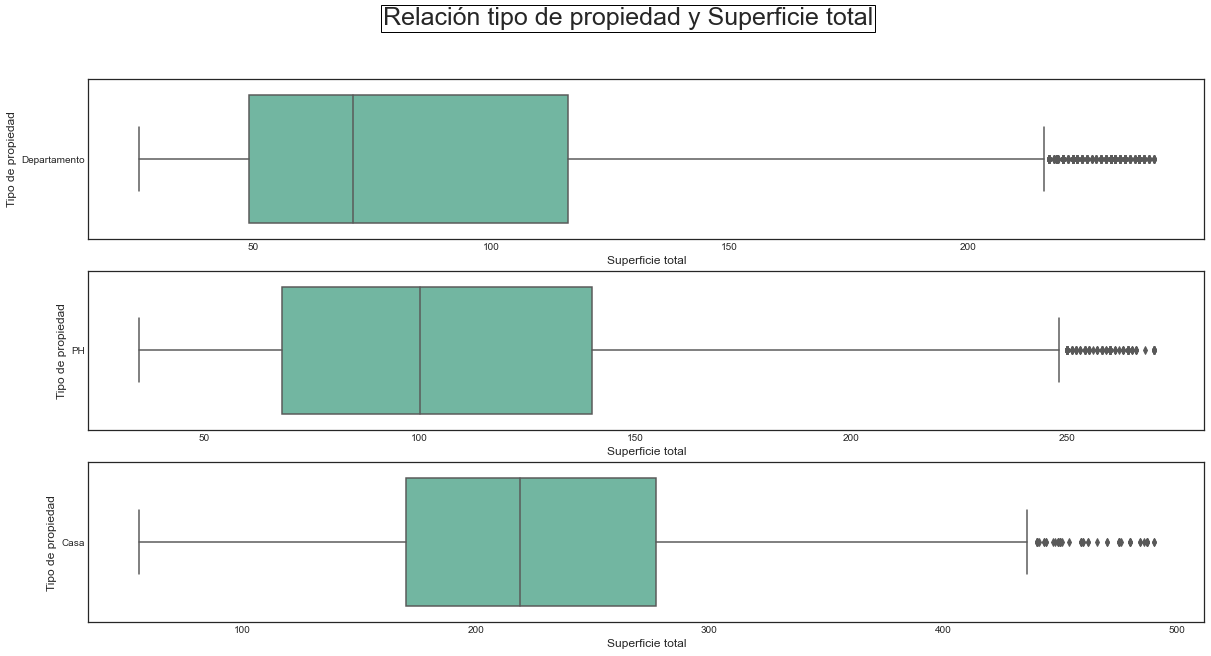

In [46]:
# Realizo los boxplot por tipo de propiedad sin outliers.
plt.figure (figsize=(20,10))
plt.suptitle('Relación tipo de propiedad y Superficie total',fontsize=25,bbox={'facecolor':'1','pad':2})

plt.subplot(3,1,1)
ax=sns.boxplot(data=df_dpto,x='Superficie_total',y='Tipo_de_propiedad',color='mediumaquamarine',palette='Set2')
plt.xlabel('Superficie total', fontsize=12)
plt.ylabel('Tipo de propiedad', fontsize=12)

plt.subplot(3,1,2)
ax=sns.boxplot(data=df_ph,x='Superficie_total',y='Tipo_de_propiedad',color='mediumaquamarine',palette='Set2')
plt.xlabel('Superficie total', fontsize=12)
plt.ylabel('Tipo de propiedad', fontsize=12)

plt.subplot(3,1,3)
ax=sns.boxplot(data=df_casa,x='Superficie_total',y='Tipo_de_propiedad',color='mediumaquamarine',palette='Set2')
plt.xlabel('Superficie total', fontsize=12)
plt.ylabel('Tipo de propiedad', fontsize=12)

plt.show()

Ahora podemos observar los boxplot mucho más claros. La asimetría de los datos nos indica que los datos no están distribuidos normalmente. La dispersión más amplia la encontramos en el tipo Casa al igual que la Superficie total más alta.

In [47]:
# Realizo un filtro delimitando la superficie total a los valores que determinamos con el rango intercuartilico IQR
df = pd.DataFrame (df[(df.Superficie_total >= 26) & (df.Superficie_total <= 492.0)])

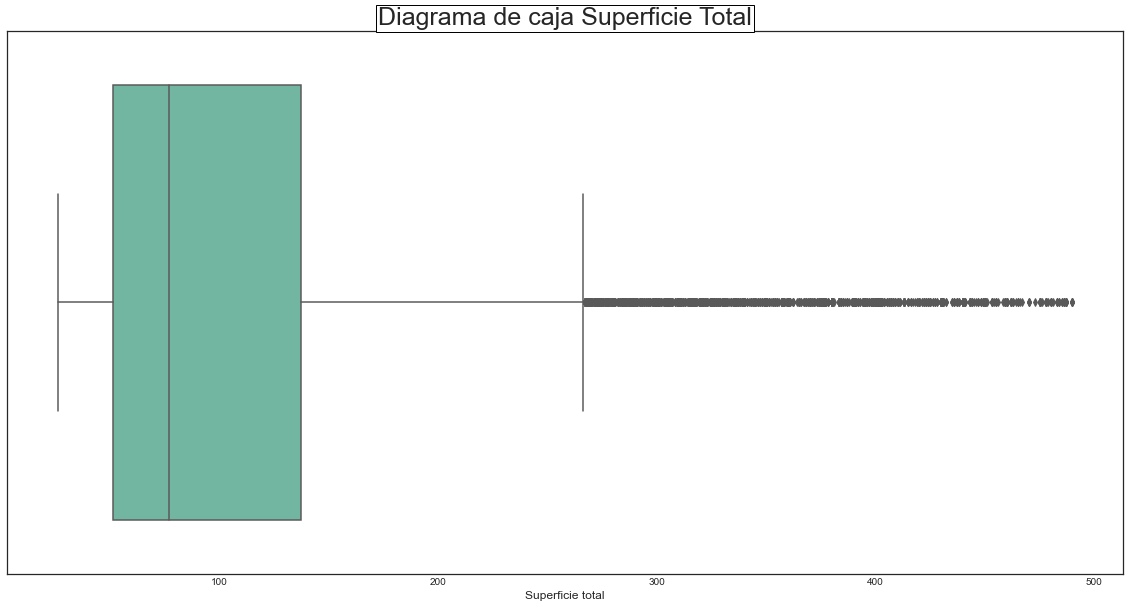

count    88207.000000
mean       105.009368
std         73.687543
min         26.000000
25%         51.000000
50%         77.000000
75%        137.000000
max        490.000000
Name: Superficie_total, dtype: float64

In [48]:
# Repito boxplot de la Superficie total pero sin desagregar por tipo de propiedad y sumo un describe para analizar la metrica.
ax= sns.boxplot (data =df, x ='Superficie_total',color='mediumaquamarine',palette='Set2')
ax.set_title ('Diagrama de caja Superficie Total',
              fontsize=25,bbox={'facecolor':'1','pad':2})
plt.xlabel('Superficie total', fontsize=12)
plt.show()
df.Superficie_total.describe ()

Al consolidar los tres tipos de propiedad nuestro diagrama de caja nos muestra muchos más valores atípicos. Esto se debe a la gran dispersión que existe entre los diferentes tipos de propiedad sin embargo aún podemos apreciar la mediana del conjunto total de nuestro dataset.

In [49]:
# Verifico que se cumpla la condición que la Superficie total es mayor que la superficie cubierta.
mascara = df.Superficie_total > df.Superficie_cubierta
print (mascara)

1          True
2         False
3          True
5         False
6         False
          ...  
146554     True
146555     True
146556     True
146557    False
146558     True
Length: 88207, dtype: bool


In [50]:
# Dado que no se cumple la condición realizo un nuevo filtro.
df = pd.DataFrame(df[df.Superficie_total > df.Superficie_cubierta])
# Imprimo la cantidad de filas y columnas para ver cuantos datos perdemos por error de carga.
print('Cantidad de filas y columnas:',df.shape)

Cantidad de filas y columnas: (63777, 11)


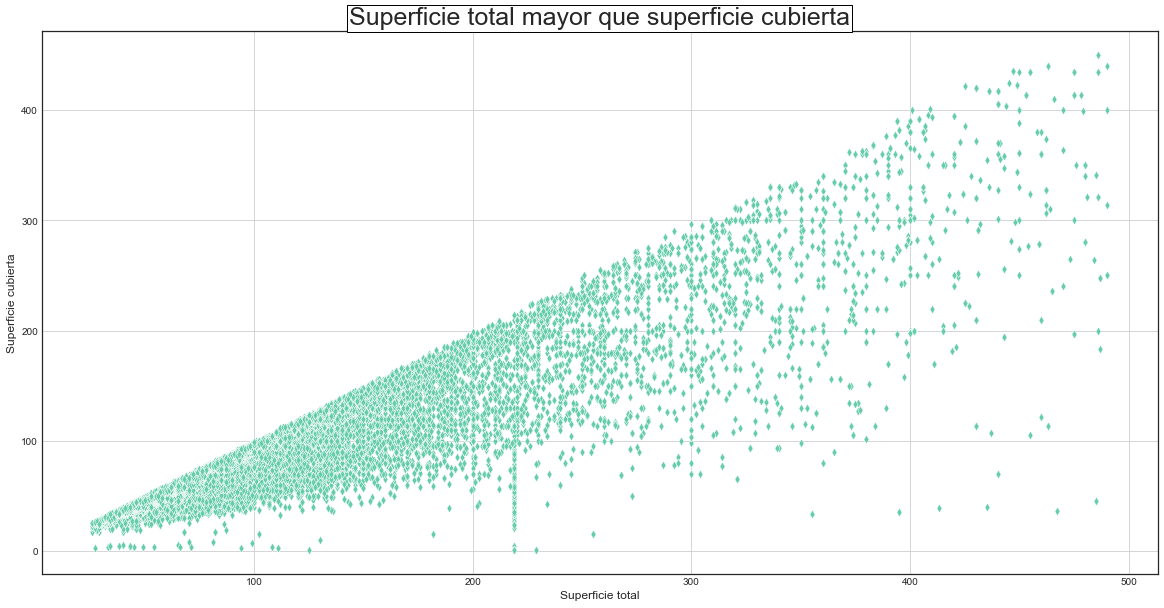

In [51]:
# Grafico para confirmar que después del recorte del dataset ya ninguna propiedad tiene una superficie cubierta mayor a la superficie total.
ax=sns.scatterplot(data=df, x='Superficie_total', y='Superficie_cubierta',color='mediumaquamarine', marker= 'd',palette="Set2")
ax.set_title ('Superficie total mayor que superficie cubierta',fontsize=25,bbox={'facecolor':'1','pad':2})
plt.xlabel('Superficie total', fontsize=12)
plt.ylabel('Superficie cubierta', fontsize=12)
plt.grid()
plt.show()

Podemos observar claramente como la Superficie total delimita a la Superficie cubierta.

In [52]:
# Ahora aplicaremos el rango intercuatilico IQR pero al precio de las propiedades.
unique= df['Tipo_de_propiedad'].unique()
for x in unique:
    Q1 = df[df['Tipo_de_propiedad']==x]['Precio'].quantile(0.25)
    Q3 = df[df['Tipo_de_propiedad']==x]['Precio'].quantile(0.75)
    IQR = Q3 - Q1
    precio_min = df[df['Tipo_de_propiedad']==x]['Precio'].quantile(0.01)
    precio_max = Q3 + (IQR*1.5)
    print(x)
    print("El precio maximo es {}, el precio minimo es {} y el IQR {}" .format(precio_max,precio_min,IQR))
    print('------------------------------------------------------------------------------')

PH
El precio maximo es 452725.0, el precio minimo es 69000.0 y el IQR 125150.0
------------------------------------------------------------------------------
Departamento
El precio maximo es 500750.0, el precio minimo es 62000.0 y el IQR 148500.0
------------------------------------------------------------------------------
Casa
El precio maximo es 730000.0, el precio minimo es 95000.0 y el IQR 200000.0
------------------------------------------------------------------------------


In [53]:
# Divido el dataset por tipo de propiedad para graficar su distribución sin los outlier.
df_ph=df_ph[(df_ph.Precio<=452725.0)&(df_ph.Precio>=69000.0)]
df_dpto=df_dpto[(df_dpto.Precio<=500750.0)&(df_dpto.Precio>=62000.0)]
df_casa=df_casa[(df_casa.Precio<=730000.0)&(df_casa.Precio>=95000.0)]

Una vez más podemos observar la mediana por cada tipo de propiedad luego de realizar nuestro proceso ETL sobre la métrica precio. Nos volvemos a encontrar con una distribución asimétrica donde los valores más altos pertenecen al segmento tipo casa, mientras que la dispersión del precio es muy similar en casa Tipo de propiedad.

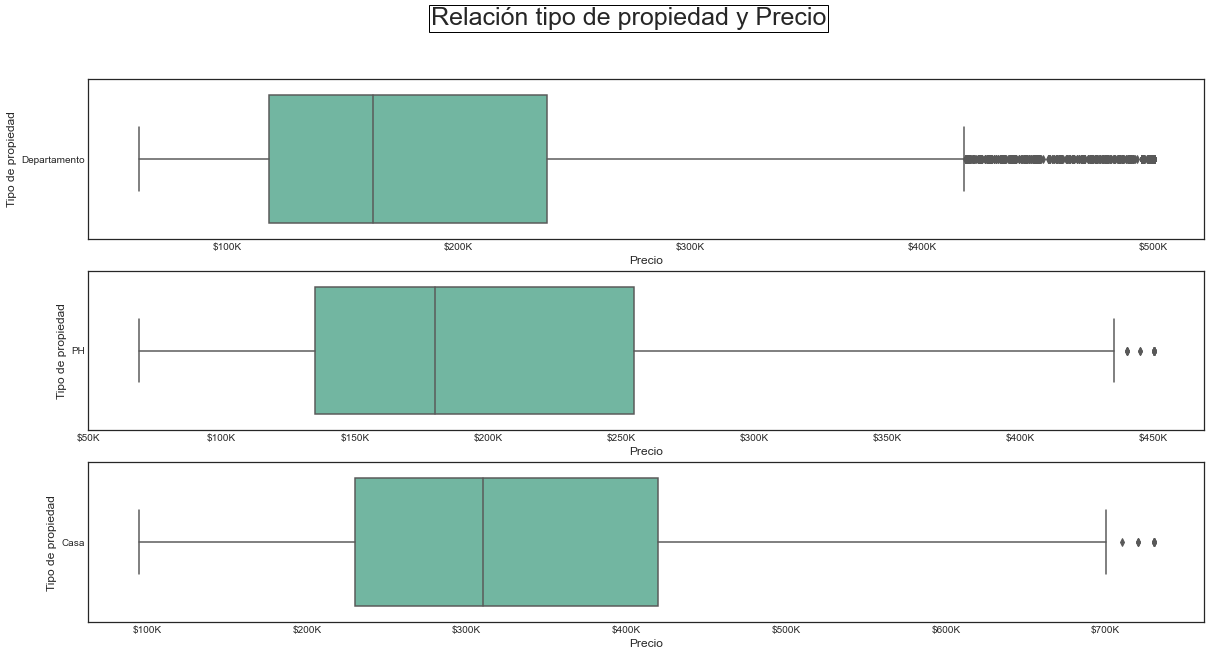

In [54]:
# Grafico los boxplot por tipo de propiedad sin outliers del atributo Precio
plt.figure (figsize=(20,10))
plt.suptitle('Relación tipo de propiedad y Precio',fontsize=25,bbox={'facecolor':'1','pad':2})
# Defino una función que me permita abreviar los ceros de los miles o millones con una letra y agrego el signo $
def currency(x, pos):
    if x >= 1e6:
        s = '${:1.1f}M'.format(x*1e-6)
    else:
        s = '${:1.0f}K'.format(x*1e-3)
    return s

plt.subplot(3,1,1)
ax=sns.boxplot(data=df_dpto,x='Precio',y='Tipo_de_propiedad',color='mediumaquamarine',palette='Set2')
plt.xlabel('Precio', fontsize=12)
plt.ylabel('Tipo de propiedad', fontsize=12)
ax.xaxis.set_major_formatter(currency)

plt.subplot(3,1,2)
ax=sns.boxplot(data=df_ph,x='Precio',y='Tipo_de_propiedad',color='mediumaquamarine',palette='Set2')
plt.xlabel('Precio', fontsize=12)
plt.ylabel('Tipo de propiedad', fontsize=12)
ax.xaxis.set_major_formatter(currency)

plt.subplot(3,1,3)
ax=sns.boxplot(data=df_casa,x='Precio',y='Tipo_de_propiedad',color='mediumaquamarine',palette='Set2')
plt.xlabel('Precio', fontsize=12)
plt.ylabel('Tipo de propiedad', fontsize=12)
ax.xaxis.set_major_formatter(currency)

plt.show()

In [55]:
# Realizo un nuevo corte delimitando la columna Precio para quedarme con las instancias que determinamos con el rango intercuartilico IQR.
df = pd.DataFrame (df[(df.Precio > 62000) & (df.Precio < 730000)])
print('Cantidad de filas y columnas:',df.shape)

Cantidad de filas y columnas: (60771, 11)


In [56]:
# Realizo el mismo corte delimitando la columna Precio pero para x_train
df = pd.DataFrame (df[(df.Precio > 45000) & (df.Precio < 624000)])
print('Cantidad de filas y columnas:',df.shape)

Cantidad de filas y columnas: (59875, 11)


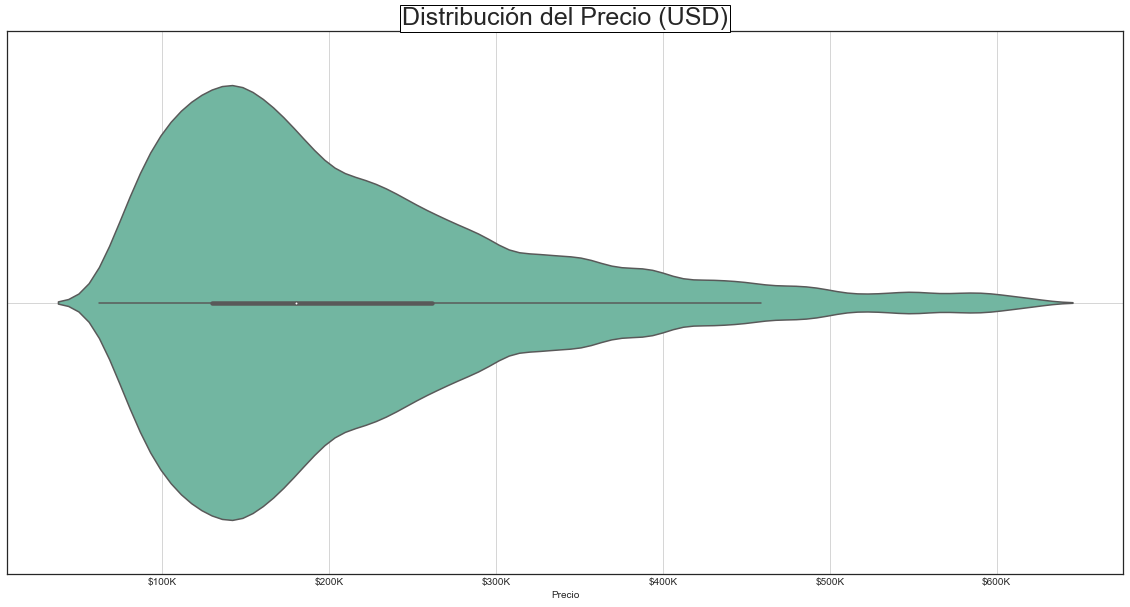

count     59875.000000
mean     211419.684860
std      111609.906516
min       62158.000000
25%      130000.000000
50%      180000.000000
75%      261600.000000
max      620685.000000
Name: Precio, dtype: float64

In [57]:
# Realizo estadísticos y algunos gráficos que me permitan verificar si hacen sentido los recortes. 
ax = sns.violinplot (data =df, x = 'Precio',color='mediumaquamarine',palette='Set2')
ax.set_title ('Distribución del Precio (USD)',
              fontsize=25,bbox={'facecolor':'1','pad':2})
ax.xaxis.set_major_formatter(currency)
plt.grid()
plt.show()
df.Precio.describe ()

Realizo un diagrama de violín para el conjunto total de nuestro dataset para mostrar la forma de distribución del precio. De esta manera en un único grafico podemos observar la densidad de los datos, su mediana como así también el intervalo de confianza y el rango intercuartílico.

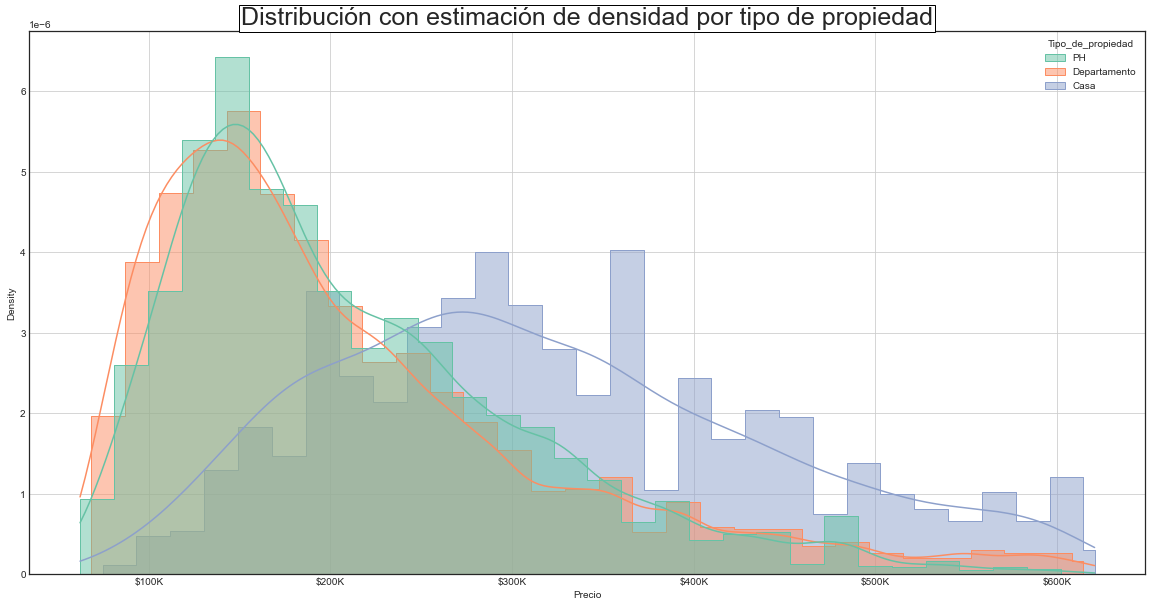

In [58]:
# Realizo un histograma de la relación precio y tipo de propiedad sobre el dataset completo sin outliers.
# La estimación de la densidad de Kernel proporciona información complementaria sobre la forma de la distribución.
ax= sns.histplot(data=df, x='Precio', hue= 'Tipo_de_propiedad',bins=30, palette='Set2', kde=True,multiple='dodge',
             element='step',stat='density', common_norm=False) 
ax.set_title ('Distribución con estimación de densidad por tipo de propiedad',
              fontsize=25,bbox={'facecolor':'1','pad':2})
ax.xaxis.set_major_formatter(currency)
plt.grid()
plt.show()
# Utilice la normalización de densidad independiente para poder comparar la distribución por tipo de propiedad.

Gráfico la distribución por tipo de propiedad con un gráfico de barras para hacer más visual lo observado nuestro diagrama de caja. Obtenemos las mismas conclusiones.

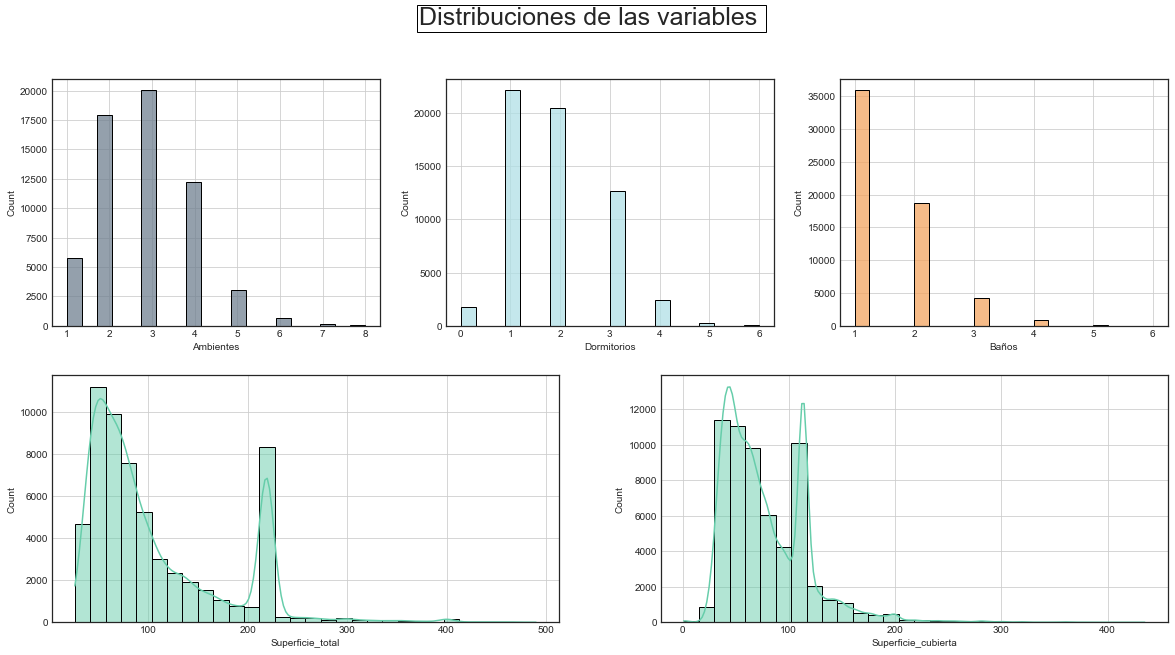

In [59]:
# Realizo las distribuciones de cada variable.
plt.figure (figsize=(20,10))
plt.suptitle('Distribuciones de las variables ',fontsize=25,bbox={'facecolor':'1','pad':2})

plt.subplot(2,3,1)
sns.histplot(data=df, x='Ambientes', kde=False, color='slategray',bins=20)
plt.grid()

plt.subplot(2,3,2)
sns.histplot(data=df, x='Dormitorios', kde=False, color='powderblue',bins=20)
plt.grid()

plt.subplot(2,3,3)
sns.histplot(data=df, x='Baños', kde=False, color='sandybrown',bins=20)
plt.grid()

plt.subplot (2,2,3)
sns.histplot(data=df, x='Superficie_total', kde=True, color='mediumaquamarine',bins=30)
plt.grid()

plt.subplot (2,2,4)
sns.histplot(data=df, x='Superficie_cubierta', kde=True, color='mediumaquamarine',bins=30)
plt.grid()

plt.show()

**Distribuciones de las variables:** Las concentraciones de nuestros datos se encuentran de 2 a 4 ambientes y 1 o 2 baños. Además, queda presentado visualmente las distribuciones de las Superficies.

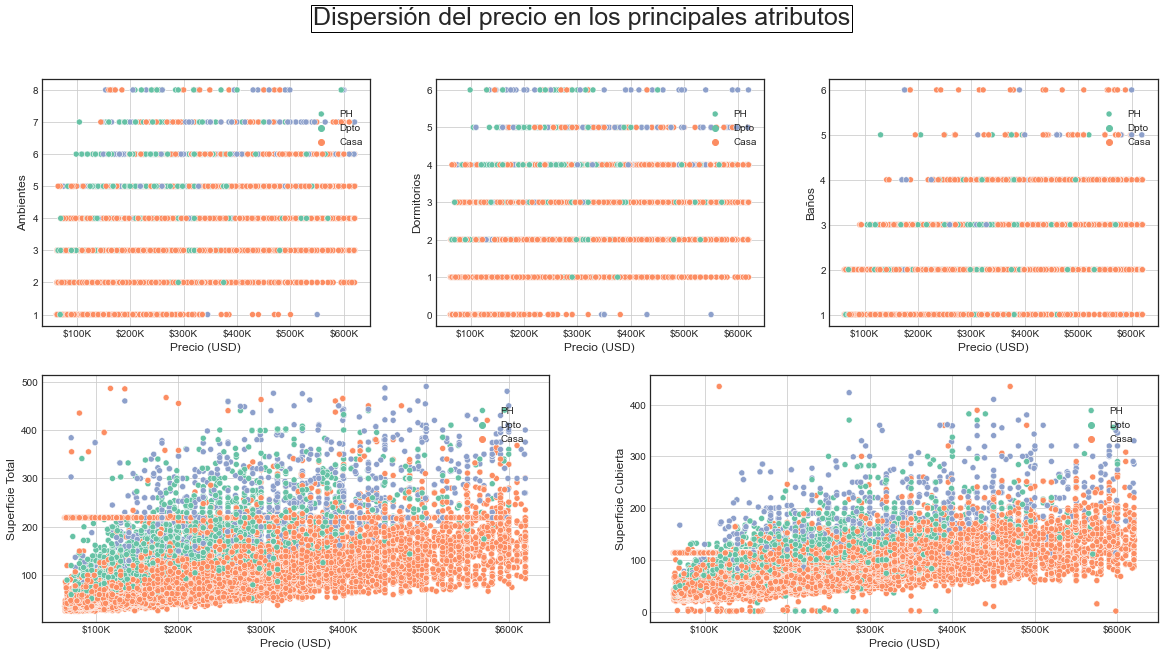

In [60]:
# Me interesa ver la dispersión por tipo de propiedad vs precio.
plt.figure (figsize=(20,10))
plt.suptitle('Dispersión del precio en los principales atributos',fontsize=25,bbox={'facecolor':'1','pad':2})

plt.subplot(2,3,1)
ax =sns.scatterplot(x='Precio', y='Ambientes',hue='Tipo_de_propiedad', data=df,palette='Set2')
plt.grid()
ax.xaxis.set_major_formatter(currency)
plt.xlabel('Precio (USD)', fontsize=12)
plt.ylabel('Ambientes', fontsize=12)
labels = ['PH','Dpto','Casa']
plt.legend(labels= labels,bbox_to_anchor=(0.9, 0.8),loc='center', borderaxespad=-1)

plt.subplot(2,3,2)
ax =sns.scatterplot(x='Precio', y='Dormitorios',hue='Tipo_de_propiedad',data=df,palette='Set2')
plt.grid()
ax.xaxis.set_major_formatter(currency)
plt.xlabel('Precio (USD)', fontsize=12)
plt.ylabel('Dormitorios', fontsize=12)
plt.legend(labels= labels,bbox_to_anchor=(0.9, 0.8),loc='center', borderaxespad=-1)

plt.subplot(2,3,3)
ax =sns.scatterplot(x='Precio', y='Baños',hue='Tipo_de_propiedad', data=df,palette='Set2')
plt.grid()
ax.xaxis.set_major_formatter(currency)
plt.xlabel('Precio (USD)', fontsize=12)
plt.ylabel('Baños', fontsize=12)
plt.legend(labels= labels,bbox_to_anchor=(0.9, 0.8),loc='center', borderaxespad=-1)

plt.subplot (2,2,3)
ax =sns.scatterplot(x='Precio', y='Superficie_total',hue='Tipo_de_propiedad', data=df,palette='Set2')
plt.grid()
ax.xaxis.set_major_formatter(currency)
plt.xlabel('Precio (USD)', fontsize=12)
plt.ylabel( 'Superficie Total', fontsize=12)
plt.legend(labels= labels,bbox_to_anchor=(0.9, 0.8),loc='center', borderaxespad=-1)

plt.subplot (2,2,4)
ax =sns.scatterplot(x='Precio', y='Superficie_cubierta',hue='Tipo_de_propiedad', data=df,palette='Set2')
ax.xaxis.set_major_formatter(currency)
plt.grid()
plt.xlabel('Precio (USD)', fontsize=12)
plt.ylabel( 'Superficie Cubierta', fontsize=12)
plt.legend(labels= labels,bbox_to_anchor=(0.9, 0.8),loc='center', borderaxespad=-1)

plt.show()

Podemos notar que la distribución de nuestra variable a predecir no guarda una relación lineal con ninguna de nuestros atributos. Hay una tendencia casi imperceptible que a medida que aumenta el precio crece la superficie, pero tampoco se respeta en todos los casos. Nos encontramos propiedades donde la superficie es grande y no así su precio y viceversa. Por tanto, no podemos ser categóricos con la relación hasta que realicemos las correlaciones.

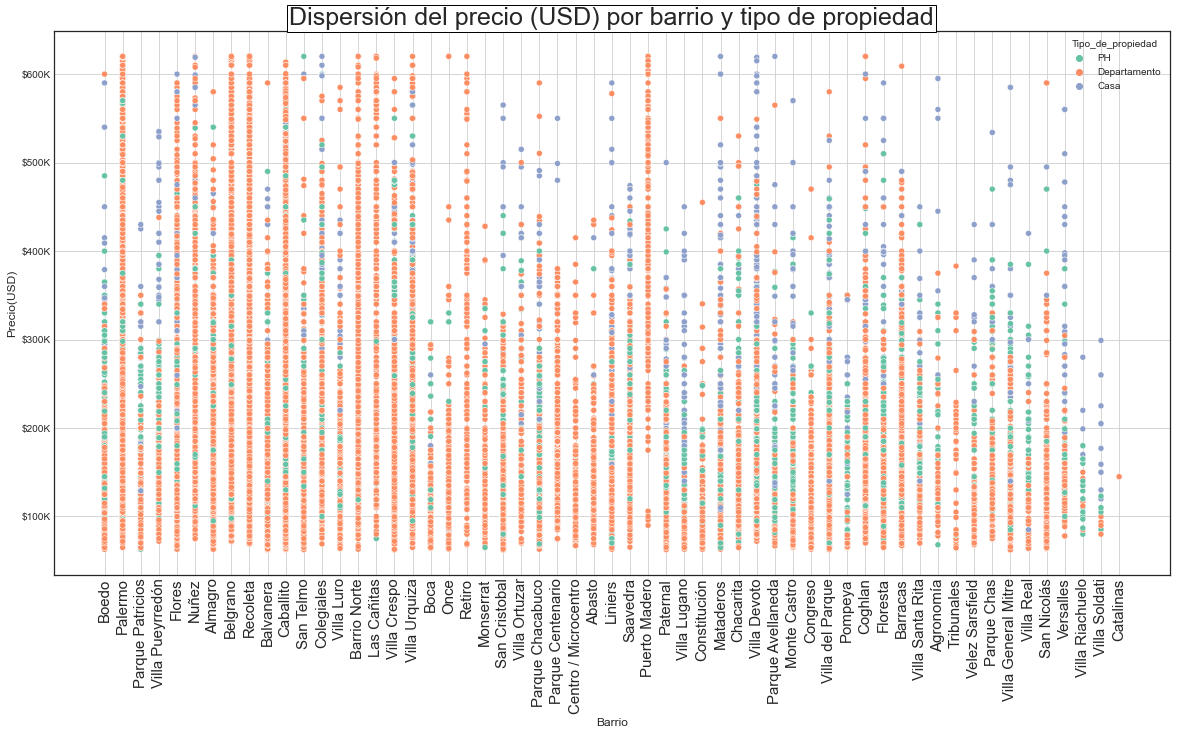

In [61]:
# Antes de ir a las correlaciones quiero ver la disperción del precio por barrio y tipo de propiedad.
ax =sns.scatterplot(x='Barrio', y='Precio',hue='Tipo_de_propiedad', data=df,palette='Set2')
ax.yaxis.set_major_formatter(currency)
plt.tick_params(axis='x', labelrotation=90, labelsize =15)
plt.xlabel ('Barrio', fontsize=12)
plt.ylabel( 'Precio(USD)', fontsize=12)
ax.set_title ('Dispersión del precio (USD) por barrio y tipo de propiedad',
              fontsize=25,bbox={'facecolor':'1','pad':2})
plt.grid()
plt.show()

En cuanto a la distribución por barrio es llamativo como predomina el tipo Departamento. Podemos establecer rápidamente los barrios más caros como así mismo donde tenemos más cantidad de propiedades publicadas.

In [62]:
# Determino las variables que me interesan correlacionar.
correlacion = df[['Ambientes','Dormitorios','Baños','Superficie_total',
                  'Superficie_cubierta', 'Precio']].corr()

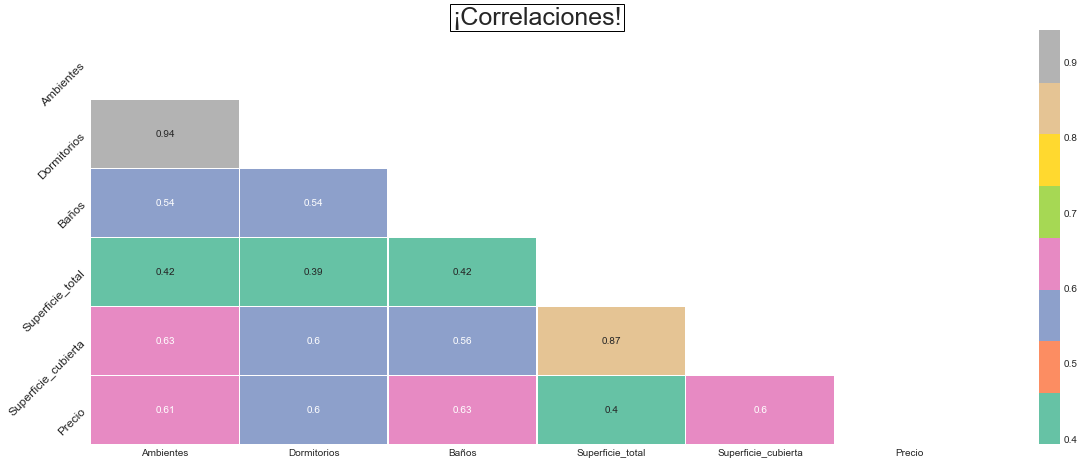

In [63]:
# y ahora si realizo un mapa de calor para ver la correlación.
matrix=np.triu(correlacion)
ax = sns.heatmap(correlacion,cmap='Set2', annot = True, linewidths=.5,mask=matrix)
plt.subplots_adjust(top=0.7)
ax.set_title ('¡Correlaciones!',fontsize=25,bbox={'facecolor':'1','pad':2})
plt.tick_params(axis='y', labelrotation=45, labelsize =12)
plt.show()

Para completar nuestro análisis las correlaciones resultan clave. Podemos ver como en nuestro target (valor a predecir) ninguna variable tiene un peso para considerar. A su vez, las variables ambientes y dormitorios como la superficie total y cubierta mantienen una relación cercana a 1, con 0,86 y 0,8 respectivamente. Factores a considerar al momento de realizar nuestros modelos.

**Realizamos un Pairplot como síntesis de lo trabajado hasta el momento antes transformar nuestras variables categóricas.**

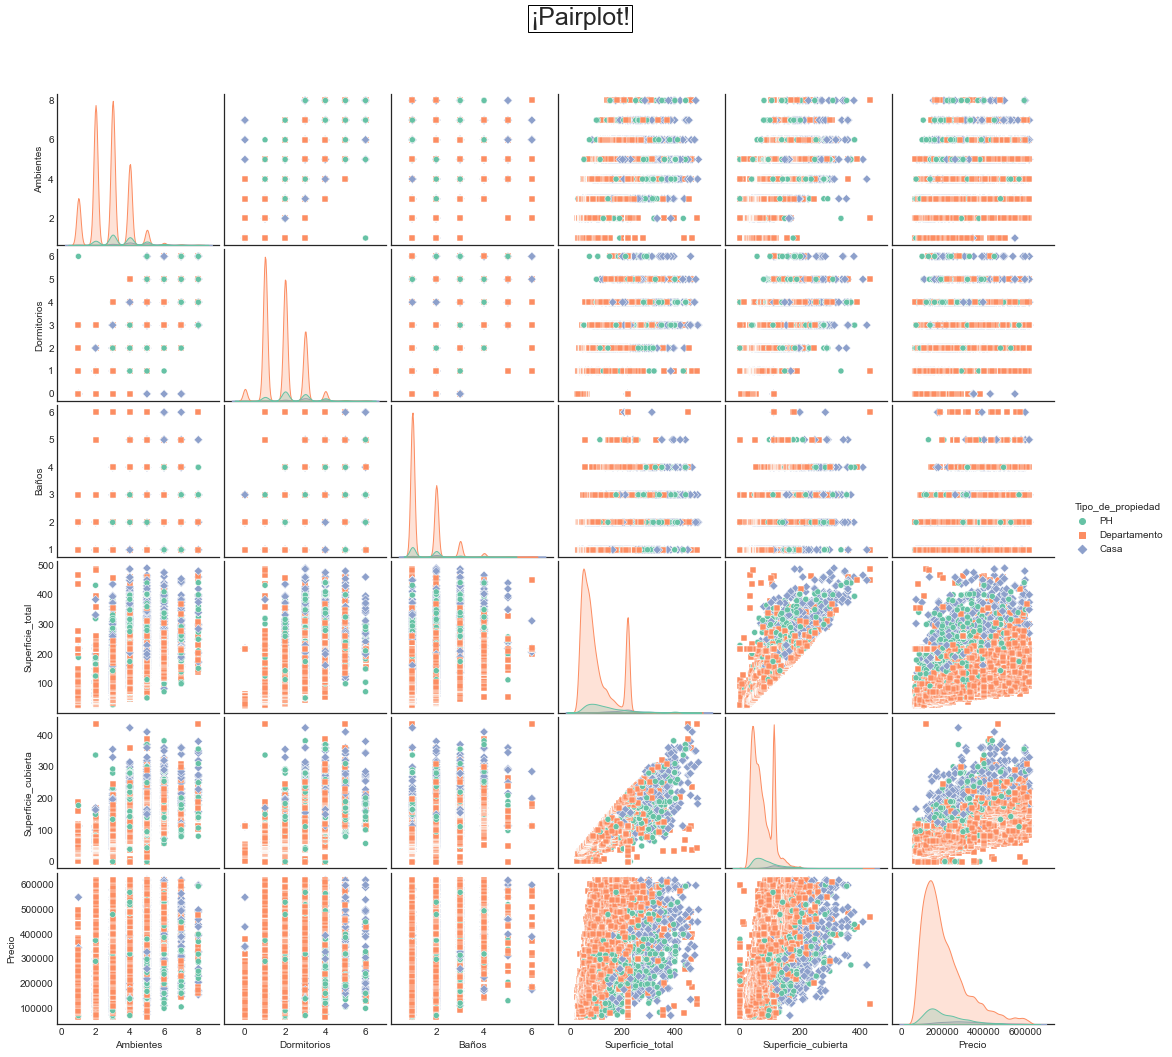

In [64]:
g= sns.pairplot(df,x_vars=['Ambientes','Dormitorios','Baños','Superficie_total','Superficie_cubierta','Precio'],
                y_vars=['Ambientes','Dormitorios','Baños','Superficie_total','Superficie_cubierta','Precio'], 
                hue = 'Tipo_de_propiedad',palette='Set2',markers=['o', 's', 'D'])
plt.subplots_adjust(top=0.9)
g.fig.suptitle ('¡Pairplot!',fontsize=25,bbox={'facecolor':'1','pad':2})
plt.show()

**Antes de continuar, dividimos nuestro set de Datos.**

In [65]:
# Selecciono las variables predictoras (X) y la variable a predecir (y).
X, y = df.drop(columns=['Precio', 'Localidad']), df[['Precio']] 
# Sacamos la Localidad de nuestras variables predictoras por tener una sola categoria (Capital Federal).
# Si realizamos el encodear a una variable "única" el modelo iba a sobre ajustar.

In [66]:
# Vemos X
X.head(3)

,Latitud,Longitud,Barrio,Ambientes,Dormitorios,Baños,Superficie_total,Superficie_cubierta,Tipo_de_propiedad
1,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,PH
3,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,PH
8,-34.639598,-58.419612,Parque Patricios,1.0,1.0,1.0,45.0,37.0,PH


In [67]:
# Vemos y
y.head(3)

,Precio
1,159000.0
3,295000.0
8,89000.0


**Separamos entre Train y Test.**

In [68]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [69]:
### ¡SPOILER ALERT! ###


# Realizamos una copia de nuestro datos, con el corte de datos de testeo. Luego del preprocesamiento, pero antes del encoders.
#¿Por qué? Lo vamos a necesitar más adelante para interpretar nuestros modelos con la variables categoricas..

# Primero incluimos nuestra variables predictoras.
error_modelo_bm = pd.DataFrame (x_test.copy()) 
# Ahora sumamos nuestro Target.
error_modelo_bm['Precio']=y_test.copy() 
# Reseteamos el índice para luego poder concatenar nuestras predicciones.
error_modelo_bm= error_modelo_bm.reset_index(drop=True) 

### "Encoders"
* Vamos a armar un pipeline para transformar las variables categóricas a numéricas.

In [70]:
# Tomamos una lista con los atributos del dataframe X. Será útil para el pipeline.
featnames=list(x_train.columns)

class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Selecciona features por su nombre. Servirá para aplicar pipelines a distintos datasets
    """
    def __init__(self, columns):
        """columns = lista de column names"""
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.columns]

In [71]:
# Armamos un pipeline pero solo le colocamos 1 step --> Este imputará la media del target.
pipe = Pipeline([
    #Selecciona todas las columnas disponibles en el dataframe de train
    ('selector', FeatureSelector(columns=featnames))
    #Categorical Treatment
    ,('categ_imputer', CategoricalImputer(imputation_method='missing') ) # Coloca texto "missing" donde hay NaNs en variables categóricas
    ,('categ_rare_encoder', RareLabelEncoder(tol=0.01, n_categories=1) ) # Método para quitar niveles muy poco frecuentes 
    ,('categ_encoder', feature_engine.encoding.MeanEncoder()) # Método para convertir categóricas a numéricas. 
                        ])

In [72]:
# Fitteamos el pipeline a los datos X e Y que tenemos en train
pipe_fitted = pipe.fit(x_train, y_train.values.ravel())

In [73]:
# Para ver los resultados, primero recordamos como eran nuestros datos
x_train

,Latitud,Longitud,Barrio,Ambientes,Dormitorios,Baños,Superficie_total,Superficie_cubierta,Tipo_de_propiedad
41503,-34.594828,-58.445927,Villa Crespo,2.0,1.0,1.0,45.0,41.0,Departamento
137529,-34.542750,-58.460145,Nuñez,2.0,1.0,1.0,86.0,51.0,Departamento
70601,-34.612687,-58.412600,Once,3.0,2.0,1.0,63.0,60.0,Departamento
97708,-34.611575,-58.363031,Puerto Madero,3.0,2.0,2.0,76.0,66.0,Departamento
65207,-34.624052,-58.449589,Flores,4.0,3.0,2.0,116.0,112.0,Departamento
...,...,...,...,...,...,...,...,...,...
132683,-34.571150,-58.423297,Palermo,2.0,1.0,2.0,81.0,77.0,Departamento
90585,-34.603304,-58.455466,Villa Crespo,1.0,1.0,1.0,50.0,44.0,Departamento
2096,-34.565484,-58.471073,Coghlan,1.0,1.0,1.0,36.0,32.0,Departamento
37062,-34.603900,-58.442410,Parque Centenario,4.0,3.0,3.0,89.0,80.0,Departamento


In [74]:
x_train = pipe_fitted.transform(x_train)
x_train

,Latitud,Longitud,Barrio,Ambientes,Dormitorios,Baños,Superficie_total,Superficie_cubierta,Tipo_de_propiedad
41503,-34.594828,-58.445927,209980.566792,2.0,1.0,1.0,45.0,41.0,211719.576468
137529,-34.542750,-58.460145,210813.553885,2.0,1.0,1.0,86.0,51.0,211719.576468
70601,-34.612687,-58.412600,210020.986465,3.0,2.0,1.0,63.0,60.0,211719.576468
97708,-34.611575,-58.363031,210020.986465,3.0,2.0,2.0,76.0,66.0,211719.576468
65207,-34.624052,-58.449589,212446.910788,4.0,3.0,2.0,116.0,112.0,211719.576468
...,...,...,...,...,...,...,...,...,...
132683,-34.571150,-58.423297,208748.234388,2.0,1.0,2.0,81.0,77.0,211719.576468
90585,-34.603304,-58.455466,209980.566792,1.0,1.0,1.0,50.0,44.0,211719.576468
2096,-34.565484,-58.471073,210020.986465,1.0,1.0,1.0,36.0,32.0,211719.576468
37062,-34.603900,-58.442410,204430.410345,4.0,3.0,3.0,89.0,80.0,211719.576468


In [75]:
x_test = pipe_fitted.transform(x_test)

#### **¡A entrenar!**
* Vamos a volver a entrenar el `Árbol de desicón` implementado en el Sprint Project 01 pero ahora con este nuevo dataset transformado.

In [76]:
tree = DecisionTreeRegressor(max_depth= 17,random_state=42)
tree.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=17, random_state=42)

In [77]:
# Realizo las predicciones.
y_train_pred = tree.predict(x_train)
y_test_pred = tree.predict(x_test)

Modelo: Árbol de Decisión
R2 en Train: 0.9664706385238138
R2 en test: 0.8410734194024072
--------------------------
RMSE en train: 20500.437734098123
RMSE en test: 43934.49392362272


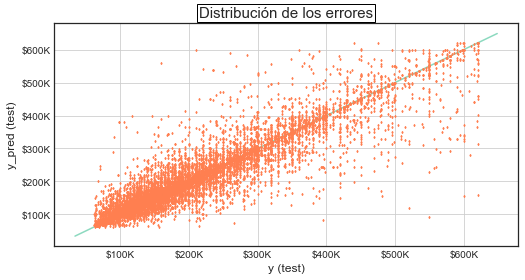

In [78]:
# Evaluamos con las mismas métricas del sprint Project 01 para poder comparar.
models = ['Árbol de Decisión']

for i, model in enumerate([tree]):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    print(f'Modelo: {models[i]}')
    
    r2_train= metrics.r2_score(y_train, y_train_pred)
    r2_test= metrics.r2_score(y_test, y_test_pred)
    

    RMSE_train=np.sqrt(mean_squared_error(y_train,y_train_pred))
    RMSE_test=np.sqrt(mean_squared_error(y_test,y_test_pred))

    print("R2 en Train:", r2_train)
    print("R2 en test:", r2_test)
    print("--------------------------")
    print("RMSE en train:",RMSE_train)
    print("RMSE en test:",RMSE_test)
    

    plt.figure(figsize = (14,4))
   
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2,c='coral', marker= 'd')
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-',c='mediumaquamarine', alpha=0.75, zorder=0)
    plt.grid()
    plt.xlabel('y (test)',fontsize=12)
    plt.ylabel('y_pred (test)',fontsize=12)
    ax.yaxis.set_major_formatter(currency)
    ax.xaxis.set_major_formatter(currency)
    ax.set_title ('Distribución de los errores',
              fontsize=15,bbox={'facecolor':'1','pad':2})
    
    plt.tight_layout()
    plt.show()

#### Evaluación y conclusiones modelo benchmark
* Así denominaremos a nuestro modelo simple del primer sprint. Será nuestro punto mínimo esperado y punto de partida para todos nuestro análisis.
* Nos encontramos con una mejora del modelo muy importante. En R2 en Train pasamos de un 95% en el sprint 1 a un **96%** (mejoramos sin caer en sobre ajuste) y se hace mucho más amplia la mejora en el R2 en Test partiendo de un 77% hasta llegar a un **84%**.  Recordemos que estamos utilizando los mismos hiperparámetros en ambos modelos, lo que deja en evidencia la importancia y el peso que tiene el EDA. Un buen tratamiento en el preprocesamiento de los datos resulta clave en el resultado de nuestras predicciones.  Pudimos confirmar empíricamente la frase de Georg Christian Füchsel **“Garbage in, garbage out”**, es determinante la calidad de los datos que le ingresemos a nuestro modelo para el resultado. 
* Además, evaluamos nuestro modelo por RMSE, logramos reducir en un **68%** en Train (64721 vs 20500) y un **70%**  en Test (146092 vs 43934). Continuemos trabajando para reducir aún más el RMSE optimizando el modelo con los métodos de optimización observados en el sprint 2.
---

## Interpretación modelo benchmark

In [79]:
# Alistamos nuetras prediciones para concatenarlas con nuestro dataset de testeo (creado anteriormente)
precio_pred= pd.DataFrame ({'Precio_pred':y_test_pred.copy()}) 
# La sumamos al nuevo dataset de testeo.
error_modelo_bm['Precio_pred']=precio_pred 
# Por último creamos una columana con las diferencias.
error_modelo_bm['Error']= round (error_modelo_bm.Precio - error_modelo_bm.Precio_pred) 
error_modelo_bm = error_modelo_bm.sort_values('Error',ascending=False)
error_modelo_bm.head(3)

,Latitud,Longitud,Barrio,Ambientes,Dormitorios,Baños,Superficie_total,Superficie_cubierta,Tipo_de_propiedad,Precio,Precio_pred,Error
11649,-34.651721,-58.476588,Parque Avellaneda,7.0,6.0,2.0,218.82,113.37,Casa,620000.0,160000.000000,460000.0
2565,-34.603815,-58.434263,Parque Centenario,1.0,0.0,2.0,218.82,113.37,Casa,550000.0,92983.160714,457017.0
1752,-34.628714,-58.413872,Boedo,4.0,3.0,1.0,218.82,113.37,Departamento,600000.0,157000.000000,443000.0


* Primer descubrimiento, el **TOP 3 de los errores más grandes corresponden a instancias donde en nuestro preprocesamiento imputamos sus Superficies.**
* También podemos observar en el error más grande de todos corresponde a uno de los Barrios menos frecuente, en este caso Parque Avellaneda.
* Resulta una oportunidad de mejora para nuestro modelo, eliminar los datos perdidos de Superficie que recuperarlos. De igual manera con los Barrios categorizados como `rare`.

In [80]:
# Agrupamos el dataset de testo por el error promedio por Barrio para nuesro modelo benchmark.
group_barrio_error_mean = error_modelo_bm.groupby('Barrio', as_index= False).agg({'Error' :'mean'})
group_barrio_error_mean  = group_barrio_error_mean.sort_values('Error',ascending=False)
group_barrio_error_mean.tail(3)

,Barrio,Error
29,Parque Chas,-12739.804878
49,Villa Pueyrredón,-13107.137255
50,Villa Real,-16097.555556


* En promedio los Barrios donde menos "acierta" nuestro modelo benchmark son: Villa Real, Villa Pueyrredón y Parque Chas.
* Como vimos corresponden a los Barrios donde menores instancias disponemos.

In [81]:
# Filtramos por "Error cero" y agrupamos por Barrio.
model_aciertos = (error_modelo_bm[(error_modelo_bm.Error == 0.0)])
model_aciertos_agrupados = model_aciertos.groupby('Barrio', as_index= False).agg({'Error' :'count'})
model_aciertos_agrupados = model_aciertos_agrupados.sort_values('Error',ascending=False)
model_aciertos_agrupados.head(3)

,Barrio,Error
25,Palermo,200
42,Villa Crespo,101
2,Almagro,86


* En el otro extremo, donde más coincidencias logramos son los barrios de Palermo, Villa Crespo y Almagro.
* También corresponde a los Barrios donde más instancias tenemos.

In [82]:
# Agrupamos el error promedio por Tipo de propiedad para nuesro modelo benchmark..
group_propiedad_error_mean = error_modelo_bm.groupby('Tipo_de_propiedad', as_index= False).agg({'Error' :'mean'})
group_propiedad_error_mean = group_propiedad_error_mean.sort_values('Error',ascending=True)
group_propiedad_error_mean

,Tipo_de_propiedad,Error
2,PH,-4976.675943
1,Departamento,-184.234421
0,Casa,12169.348571


* En cuanto al Tipo de propiedad, Departamento es donde más "acierta" el modelo benchmark y donde menos, Tipo Casa.
* Al igual que en al agrupamiento por Barrio esto responde a donde más y menos instancias tenemos en nuestros datos.
---
### **¡Extra!**
* **[Adicional]** En ese orden de ideas, primero vamos a mejorar la evaluación de nuestros modelos. Ahora queremos obtener una evaluación del modelo que no dependa de la división de los datos. ¿Cómo lo hacemos? 
### **¡Validación cruzada!**

In [83]:
# Aplicamos el metodo
tree_scores = cross_val_score(tree, x_train, y_train, scoring=('neg_root_mean_squared_error'),cv=4)

In [84]:
# Imprimo los resultados 
print(f"Métricas validación cruzada: {tree_scores}")
print("RMSE para Tree: %0.2f (+/- %0.2f)" % (tree_scores.mean(), tree_scores.std() * 2))

Métricas validación cruzada: [-46445.45719293 -48049.93881597 -47932.07082897 -48457.82253268]
RMSE para Tree: -47721.32 (+/- 1524.03)


* **¡Notable!** Logramos mejorar nuestra evalución y encontramos oportunidad para optimizar nuestros resultados.

### Optimización manual de hiperparámetros del modelo simple.

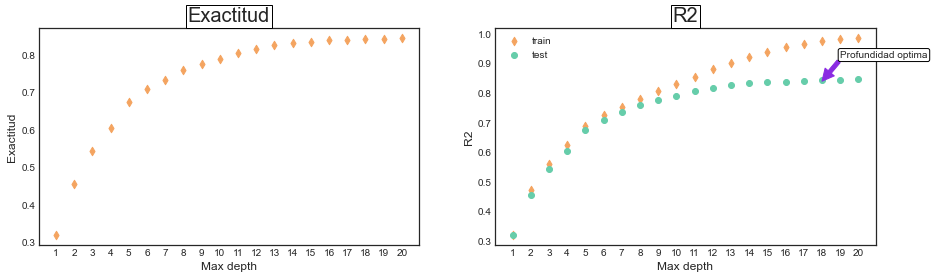

In [85]:
# Buscamos la mejor profundidad de forma "manual"(como lo hicimos en el sprint 1).
MAX_DEPTH_range = range(1, 21)
scores = []
arbol_r2_train_pred=[]
arbol_r2_test_pred=[]

for k in MAX_DEPTH_range:
    arbol_regressor = DecisionTreeRegressor(max_depth=k,random_state=42)
    arbol_regressor.fit(x_train, y_train)
    scores.append(arbol_regressor.score(x_test, y_test))
    
    y_train_pred = arbol_regressor.predict(x_train)
    arbol_r2_train = metrics.r2_score(y_train, y_train_pred)
    arbol_r2_train_pred.append(arbol_r2_train)
    
    y_test_pred = arbol_regressor.predict(x_test)
    arbol_r2_test = metrics.r2_score(y_test, y_test_pred)
    arbol_r2_test_pred.append(arbol_r2_test)
    

fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


ax1.scatter(MAX_DEPTH_range,scores,marker='d', c='sandybrown')
ax2.scatter(MAX_DEPTH_range,arbol_r2_train_pred,marker='d',c='sandybrown',label='train')
ax2.scatter(MAX_DEPTH_range,arbol_r2_test_pred,marker='o',c='mediumaquamarine',label='test')
ax2.annotate('Profundidad optima',(18,0.84),(19,0.92),arrowprops=dict(color='blueviolet'),
             bbox=dict(boxstyle='round,pad=0.2', fc='w'))

ax1.set_xticks(MAX_DEPTH_range)
ax2.set_xticks(MAX_DEPTH_range)

ax2.legend()

ax1.set_title('Exactitud',fontsize=20,bbox={'facecolor':'1','pad':2})
ax1.set_xlabel('Max depth',fontsize=12)
ax1.set_ylabel('Exactitud',fontsize=12)

ax2.set_title('R2',fontsize=20,bbox={'facecolor':'1','pad':2})
ax2.set_xlabel('Max depth',fontsize=12)
ax2.set_ylabel('R2',fontsize=12)


plt.show()

In [86]:
# Volvemos a entrenar nuevo modelo ajustando la profundidad del árbol.
tree_optimize=DecisionTreeRegressor(max_depth= 18,random_state=42)
tree_optimize.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=18, random_state=42)

In [87]:
# Realizo las predicciones.
y_train_pred_tree_optimize = tree_optimize.predict(x_train)
y_test_pred_tree_optimize = tree_optimize.predict(x_test)

Modelo: Árbol de Decisión
R2 en Train: 0.9664706385238138
R2 en test: 0.8410734194024072
--------------------------
RMSE en train: 20500.437734098123
RMSE en test: 43934.49392362272


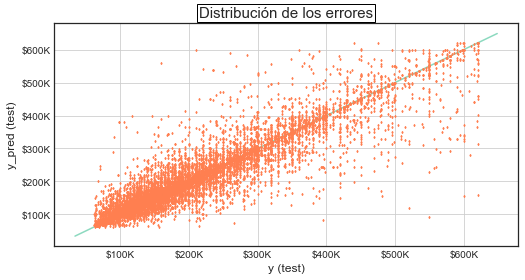

In [88]:
# Evaluamos con las mismas métricas del sprint Project 01 para poder comparar.
models = ['Árbol de Decisión']

for i, model in enumerate([tree]):
    y_train_pred_tree_optimize = model.predict(x_train)
    y_test_pred_tree_optimize = model.predict(x_test)
    
    print(f'Modelo: {models[i]}')
    
    r2_train= metrics.r2_score(y_train, y_train_pred_tree_optimize)
    r2_test= metrics.r2_score(y_test, y_test_pred_tree_optimize)
    

    RMSE_train=np.sqrt(mean_squared_error(y_train,y_train_pred_tree_optimize))
    RMSE_test=np.sqrt(mean_squared_error(y_test,y_test_pred_tree_optimize))

    print("R2 en Train:", r2_train)
    print("R2 en test:", r2_test)
    print("--------------------------")
    print("RMSE en train:",RMSE_train)
    print("RMSE en test:",RMSE_test)
    

    plt.figure(figsize = (14,4))
   
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred_tree_optimize, s =2,c='coral', marker= 'd')
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-',c='mediumaquamarine', alpha=0.75, zorder=0)
    plt.grid()
    plt.xlabel('y (test)',fontsize=12)
    plt.ylabel('y_pred (test)',fontsize=12)
    ax.yaxis.set_major_formatter(currency)
    ax.xaxis.set_major_formatter(currency)
    ax.set_title ('Distribución de los errores',
              fontsize=15,bbox={'facecolor':'1','pad':2})
    
    plt.tight_layout()
    plt.show()

*  El rendimiento de R2 mejora solamente en Train (97% vs 96%). En cuanto al error cuadrático medio, gana un 1% (43934 vs 43682).
---

### Optimización modelo simple gp_minimize

* Ahora veamos si logramos mejorar nuestros resultados con el método `gp_minimize`.

In [89]:
# Para eso definimos aquellos parámetros que queremos colocar, pero NO queremos mover luego.
FIXED_PARAMS = {         
                'random_state': 42,           
                     }

In [90]:
### Importamos la libreria y precisamos el espacio de búsqueda.
from skopt.space import Real, Integer, Categorical
cant_columnas = x_train.shape[1]
space= [          
             Categorical(['mse','mae'], name='criterion')
            ,Integer(2, 50, name='max_depth') # máxima profundidad del árbol
            ,Integer(20, 100, name='min_samples_split') # mínima cantidad de registros para abrir una rama
            ,Integer(5, 50, name='min_samples_leaf') # mínima cantidad de registros para abrir una hoja
            ,Integer(round(cant_columnas*0.1), round(cant_columnas*0.9), name='max_features') # máxima cantidad de atributos (columnas) que puede usar
            ]
# listamos los nombres de los parámetros cuyo espacio de búsqueda acabamos de definir
param_names = ['criterion','max_depth','min_samples_split','min_samples_leaf','max_features']

In [91]:
# Definimos una funcion de métricas de evaluación (para obtener RMSE).
from sklearn.metrics import roc_auc_score, mean_squared_error
def eval_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return rmse

**Lo más importante:** Determinamos nuestra "función objetivo". Es decir, lo que necesitamos que se haga en cada iteración.

In [92]:
# Delimitamos la función objetivo, que se utilizará a cada iteración de la búsqueda.
# Creamos una lista para guardar los resultados.
lista_results = []
lista_test_scores_cv = []
lista_train_scores_cv = []
lista_test_std_cv = []

@use_named_args(space)
def objective(**params):

    # seteamos los parámetros fijos
    tree.set_params(**FIXED_PARAMS)
    # y los parámetros de cada iteración (se setearán automáticamente así)
    tree.set_params(**params)
    
    # Ahora calculamos nuestros scores de test de un cross validation
    # Este objeto devuelve un array de todos los test_scores y también de los train_scores hallados -> nuestra loss será el promedio de los test_scores
    model_i_scores = cross_validate(tree, x_train, y_train, cv=3, scoring=  make_scorer(eval_metrics), return_train_score=True)
    mean_test_scores = model_i_scores['test_score'].mean()
    # Tambien nos guardamos los promedios de train para poder ver si en general se estuvo overfitteando o no 
    mean_train_scores = model_i_scores['train_score'].mean()
    # Por último, resulta interesante ver cuan volatil fueron esos test_scores. Así que tomamos su desvio standard (std)
    std_test_scores = model_i_scores['test_score'].std()
    
    # Ahora guardamos estos datos en las listas vacias que creamos antes, así nos quedan bien guardados
    lista_test_scores_cv.append(mean_test_scores) # test
    lista_train_scores_cv.append(mean_train_scores) # train
    lista_test_std_cv.append(std_test_scores) # std de test
 
    # Definimos que la funcion de perdida sea el promedio de los scores de test
    loss = mean_test_scores
    
    return loss 

In [93]:
# Ejecutamos la búsqueda de los hiperparámetros.

# Armamos una clase con tqdm para poder ver el progreso de la búsqueda
class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
    def __call__(self, res):
        self._bar.update()
        
# Cantidad de iteraciones para la búsqueda (utilizar muchas, aqui usamos 80 solo por probar)
cantidad_iteraciones = 40

# Búsqueda
res = gp_minimize(
                    objective
                    ,space
                    ,n_calls = cantidad_iteraciones
                    ,n_initial_points = int(round(cantidad_iteraciones*0.8)) # Cantidad de iteraciones iniciales random (80% es mpas que significativo, pero queremos evitar caer en un mínimo local)
                    ,n_jobs=-1
                    ,random_state = 42
                    ,verbose=0
                    ,callback=[tqdm_skopt(total=cantidad_iteraciones, desc="Process")]
                    )

Process:   0%|          | 0/40 [00:00<?, ?it/s]

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


In [94]:
# Observamos cuál fue el mejor resultado al que llegamos.
res.fun

47047.664244859596

In [95]:
# Listamos la ubicación del mínimo obtenido.
res.x

['mse', 27, 20, 5, 8]

In [96]:
# Creamos un dataframe para ver que paso en cada iteración.
df_vemos_que_paso = pd.DataFrame(res.x_iters)
df_vemos_que_paso.columns = param_names
df_vemos_que_paso['funcion_costo'] = res.func_vals
df_vemos_que_paso['numero_de_iteracion'] = df_vemos_que_paso.reset_index()['index']
df_vemos_que_paso['score_train'] = lista_train_scores_cv
df_vemos_que_paso['score_test'] = lista_test_scores_cv
df_vemos_que_paso['dif_train_test'] = df_vemos_que_paso['score_test'] - df_vemos_que_paso['score_train']
df_vemos_que_paso['std_test'] = lista_test_std_cv
df_vemos_que_paso.sort_values('funcion_costo', ascending=True, inplace=True)
df_vemos_que_paso.head(10)

,criterion,max_depth,min_samples_split,min_samples_leaf,max_features,funcion_costo,numero_de_iteracion,score_train,score_test,dif_train_test,std_test
39,mse,27,20,5,8,47047.664245,39,34042.762339,47047.664245,13004.901906,633.492920
37,mse,27,20,5,8,47047.664245,37,34042.762339,47047.664245,13004.901906,633.492920
38,mse,27,20,5,8,47047.664245,38,34042.762339,47047.664245,13004.901906,633.492920
34,mse,31,20,5,5,47776.192965,34,36145.326418,47776.192965,11630.866548,133.247441
35,mse,29,20,5,6,48095.736484,35,35436.690000,48095.736484,12659.046484,507.871580
3,mse,31,21,6,5,48278.476531,3,36869.932554,48278.476531,11408.543977,350.743514
36,mse,14,20,5,8,48279.002667,36,37757.988379,48279.002667,10521.014289,346.264678
33,mse,31,32,5,5,48380.458040,33,39371.372172,48380.458040,9009.085868,490.999064
16,mse,24,28,22,6,49995.735327,16,45002.319269,49995.735327,4993.416058,418.384537
32,mse,50,100,5,8,50387.331273,32,45677.823008,50387.331273,4709.508264,564.273236


In [97]:
# Armamos un diccionario a partir de 2 listas: la primera es los nombres que tienen los hiperparametros, y la otra son los mejores que se encontraron
mejores_hp = dict(zip(param_names, res.x))
# Pero además le agregamos aquellos hiperparametros que dejamos fijos (en nuestro caso solo fue el random_state)
mejores_hp.update(FIXED_PARAMS)

In [98]:
mejores_hp

{'criterion': 'mse',
 'max_depth': 27,
 'min_samples_split': 20,
 'min_samples_leaf': 5,
 'max_features': 8,
 'random_state': 42}

In [99]:
# Colocamos esos mejores hiperparametros en nuestro modelo
tree_optimize_gp = tree.set_params(**mejores_hp)

In [100]:
# Entrenamos ese arbol que ya tiene los hiperparametros correctos
tree_optimize_gp.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=27, max_features=8, min_samples_leaf=5,
                      min_samples_split=20, random_state=42)

In [101]:
# Realizo las predicciones.
y_train_pred_tree_optimize_gp = tree_optimize_gp.predict(x_train)
y_test_pred_tree_optimize_gp = tree_optimize_gp.predict(x_test)

Modelo: Árbol gp_minimize
R2 en Train: 0.9162072928204991
R2 en test: 0.833878060564163
--------------------------
RMSE en train: 32408.10250768493
RMSE en test: 44918.04592798093


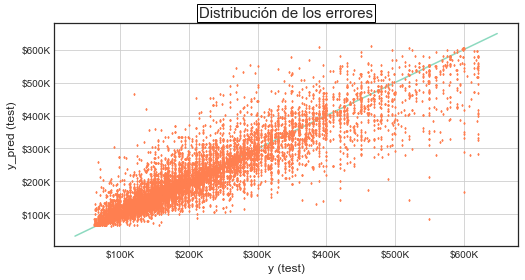

In [102]:
# Evaluamos el árbol optimizado con 'gp_minimize'.
models = ['Árbol gp_minimize']

for i, model in enumerate([tree_optimize_gp]):
    y_train_pred_tree_optimize_gp = model.predict(x_train)
    y_test_pred_tree_optimize_gp = model.predict(x_test)
    
    print(f'Modelo: {models[i]}')
    
    r2_train= metrics.r2_score(y_train, y_train_pred_tree_optimize_gp)
    r2_test= metrics.r2_score(y_test, y_test_pred_tree_optimize_gp)
    

    RMSE_train=np.sqrt(mean_squared_error(y_train,y_train_pred_tree_optimize_gp))
    RMSE_test=np.sqrt(mean_squared_error(y_test,y_test_pred_tree_optimize_gp))

    print("R2 en Train:", r2_train)
    print("R2 en test:", r2_test)
    print("--------------------------")
    print("RMSE en train:",RMSE_train)
    print("RMSE en test:",RMSE_test)
    

    plt.figure(figsize = (14,4))
   
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred_tree_optimize_gp, s =2,c='coral', marker= 'd')
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-',c='mediumaquamarine', alpha=0.75, zorder=0)
    plt.grid()
    plt.xlabel('y (test)',fontsize=12)
    plt.ylabel('y_pred (test)',fontsize=12)
    ax.yaxis.set_major_formatter(currency)
    ax.xaxis.set_major_formatter(currency)
    ax.set_title ('Distribución de los errores',
              fontsize=15,bbox={'facecolor':'1','pad':2})
    
    plt.tight_layout()
    plt.show()

* Obtuvimos un resultado superior con el árbol sin optimizar de un **2% en el RMSE** (43934 vs. 44918). Si bien no es el resutlado que esperabamos podemos observar que este modelo es más estable que nuestro benchmark. ¿Dónde lo vemos? En la distancia entre el R2 de Train y de Test logramos acortar esa brecha a 5%.
---
## Modelos Avanzados
### 1. Random Forest

In [103]:
# Creamos el modelo con los principales parámetros por defecto y lo fiteamos.
clf = RandomForestRegressor(n_estimators =100,random_state=42)
clf.fit(x_train,y_train.values.ravel())

RandomForestRegressor(random_state=42)

In [104]:
# Realizo las predicciones.
y_train_pred_clf = clf.predict(x_train)
y_test_pred_clf = clf.predict(x_test)

Modelo: Random Forest
R2 en Train: 0.9831510537058141
R2 en test: 0.903609194750939
--------------------------
RMSE en train: 14532.384029999786
RMSE en test: 34215.678985510225


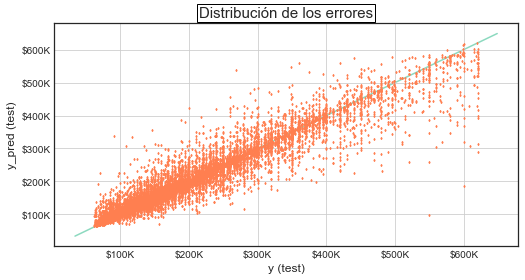

In [105]:
# Evaluamos su desempeño en el conjunto de train y de test.
models = ['Random Forest']

for i, model in enumerate([clf]):
    y_train_pred_clf = model.predict(x_train)
    y_test_pred_clf = model.predict(x_test)
    
    print(f'Modelo: {models[i]}')
    
    r2_train= metrics.r2_score(y_train, y_train_pred_clf)
    r2_test= metrics.r2_score(y_test, y_test_pred_clf)
    

    RMSE_train=np.sqrt(mean_squared_error(y_train,y_train_pred_clf))
    RMSE_test=np.sqrt(mean_squared_error(y_test,y_test_pred_clf))

    print("R2 en Train:", r2_train)
    print("R2 en test:", r2_test)
    print("--------------------------")
    print("RMSE en train:",RMSE_train)
    print("RMSE en test:",RMSE_test)
    

    plt.figure(figsize = (14,4))
   
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred_clf, s =2,c='coral', marker= 'd')
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-',c='mediumaquamarine', alpha=0.75, zorder=0)
    plt.grid()
    plt.xlabel('y (test)',fontsize=12)
    plt.ylabel('y_pred (test)',fontsize=12)
    ax.yaxis.set_major_formatter(currency)
    ax.xaxis.set_major_formatter(currency)
    ax.set_title ('Distribución de los errores',
              fontsize=15,bbox={'facecolor':'1','pad':2})
    
    plt.tight_layout()
    plt.show()

### Evaluación y conclusiones primer modelo avanzado: **`Random Forest`**
* Obtuvimos una mejora ostensible, un **22%** de progreso en el RMSE en comparación con nuestro modelo benchmarck (43934 vs 34215) pero estos resultados requieren más análisis. 
* Nos encontramos con 98% en el R2 en Train y 90% en Test, también mejoras, aunque por la distancia entre los datos de entrenamiento y los datos de testeos dentro del mismo modelo podemos inferir que hubo **“overfitting”.**
* ¿Por qué? Al por dejar los parámetros por defecto (como indica la consigna del trabajo) en la cantidad mínima de registros para abrir una rama (2) y la cantidad mínima de registros para abrir una hoja (1) llevando la pureza de GINI a su mejor expresión posible y generando el sobreajuste. 

Veamos si la optimización de los hiperparámetros con el método random search corrige este punto.

#### Optimización a traves de `RandomSearch`

In [106]:
# Armamos la grilla para Random Search
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 100, num = 10)] # Número de árboles.
max_features = ['auto', 'sqrt'] # Cantidad de features a considerar en cada split.
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Max depth en cada árbol.
max_depth.append(None)
min_samples_split = np.arange (20,100)  # Mínima cantidad de samples requeridas para hacer el split en un nodo.
min_samples_leaf = np.arange (5,50) # Mínima cantidad de samples requeridas en cada nodo de la hoja.
                                                        
random_grid = {'n_estimators':n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'bootstrap': [True] # Método de selección de muestras para el entrenamiento
             }

In [107]:
# Creamos el modelo en busca de los mejores hiperparámetros para nuestro modelo avanzado con validación cruzada.
model = RandomizedSearchCV(estimator=clf, param_distributions = random_grid,n_iter=50,
                           scoring='neg_mean_absolute_error', random_state=42, cv=3,n_jobs = -1,
                          return_train_score=True)

In [108]:
# Lo fiteamos
model.fit(x_train, y_train.values.ravel())

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41,...
                                        'min_samples_split': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 7

In [109]:
# Armamos un diccionario con los mejores hiperparámetros que encontramos con el entrenamiento
mejores_hp_random = model.best_params_

In [110]:
# Observamos esos hiperparámetros
mejores_hp_random

{'n_estimators': 66,
 'min_samples_split': 34,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [111]:
# Colocamos esos mejores hiperparametros en nuestro modelo avanzado
clf_optimize_random = clf.set_params(**mejores_hp_random)

In [112]:
# Volvemos a entrenarlo pero con los hiperparámetros optimizados con Random Search
clf_optimize_random.fit(x_train,y_train.values.ravel())

RandomForestRegressor(max_depth=100, min_samples_leaf=5, min_samples_split=34,
                      n_estimators=66, random_state=42)

In [113]:
# Realizo las predicciones.
y_train_pred_clf_optimize_random = clf_optimize_random.predict(x_train)
y_test_pred_clf_optimize_random = clf_optimize_random.predict(x_test)

Modelo: Randomforest optimizado randomsearch
R2 en Train: 0.9021505657290811
R2 en test: 0.8601320569896147
--------------------------
RMSE en train: 35021.089474702414
RMSE en test: 41216.05799526468


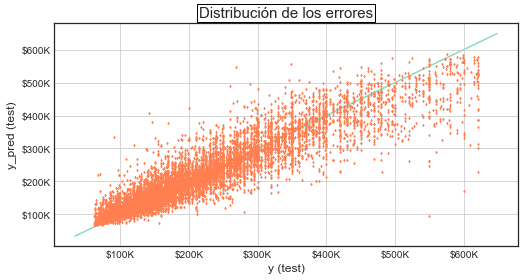

In [114]:
# Evaluamos el desempeño de los hiperparámetros encontrados por Random Search.
models = ['Randomforest optimizado randomsearch']

for i, model in enumerate([clf_optimize_random]):
    y_train_pred_clf_optimize_random = model.predict(x_train)
    y_test_pred_clf_optimize_random = model.predict(x_test)
    
    print(f'Modelo: {models[i]}')
    
    r2_train= metrics.r2_score(y_train, y_train_pred_clf_optimize_random)
    r2_test= metrics.r2_score(y_test, y_test_pred_clf_optimize_random)
    

    RMSE_train=np.sqrt(mean_squared_error(y_train,y_train_pred_clf_optimize_random))
    RMSE_test=np.sqrt(mean_squared_error(y_test,y_test_pred_clf_optimize_random))

    print("R2 en Train:", r2_train)
    print("R2 en test:", r2_test)
    print("--------------------------")
    print("RMSE en train:",RMSE_train)
    print("RMSE en test:",RMSE_test)
    

    plt.figure(figsize = (14,4))
   
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred_clf_optimize_random, s =2,c='coral', marker= 'd')
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min de ambos ejes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max de ambos ejes]
    ]
    
    ax.plot(lims, lims, 'k-',c='mediumaquamarine', alpha=0.75, zorder=0)
    plt.grid()
    plt.xlabel('y (test)',fontsize=12)
    plt.ylabel('y_pred (test)',fontsize=12)
    ax.yaxis.set_major_formatter(currency)
    ax.xaxis.set_major_formatter(currency)
    ax.set_title ('Distribución de los errores',
              fontsize=15,bbox={'facecolor':'1','pad':2})
    
    plt.tight_layout()
    plt.show()

#### Evaluación y conclusiones primer modelo avanzado optimizado: **`Random Forest` + `Random search`**
* Lo más relevante que encontramos es que, el R2 obtuvo un **90% y 86% en Train y Test respectivamente.** Por tanto, podemos concluir que la optimización mitigo e elimino el overfitting del modelo. 
* En cuanto al RMSE logramos una **mejora del 6% contra nuestro benchmark (43934 vs. 41216)**. Hasta el momento es nuestro mejor resultado (en conjunto, ganancia de RMSE y estabilidad del modelo entre Train y Test).

De todos modos, no nos apresuramos a definir nuestro modelo “ganador” y avanzamos con nuestro segundo modelo avanzado.

---

### 2. XGBoost

In [115]:
# Creamos el modelo con los principales parámetros por defecto y lo fiteamos.
xgboost = XGBRegressor(seed=42)
xgboost.fit(x_train,y_train.values.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [116]:
# y realizamos las predicciones.
y_train_pred_xgboost = xgboost.predict(x_train)
y_test_pred_xgboost = xgboost.predict(x_test)

Modelo: XGBoost
R2 en Train: 0.9004985749421556
R2 en test: 0.8624336293644591
--------------------------
RMSE en train: 35315.482427204865
RMSE en test: 40875.53954685467


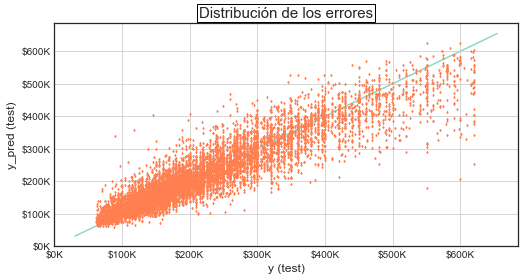

In [117]:
# Ahora si estamos listos para evaluar su desempeño en el conjunto de train y de test.
models = ['XGBoost']

for i, model in enumerate([xgboost]):
    y_train_pred_xgboost = model.predict(x_train)
    y_test_pred_xgboost = model.predict(x_test)
    
    print(f'Modelo: {models[i]}')
    
    r2_train= metrics.r2_score(y_train, y_train_pred_xgboost)
    r2_test= metrics.r2_score(y_test, y_test_pred_xgboost)
    

    RMSE_train=np.sqrt(mean_squared_error(y_train,y_train_pred_xgboost))
    RMSE_test=np.sqrt(mean_squared_error(y_test,y_test_pred_xgboost))

    print("R2 en Train:", r2_train)
    print("R2 en test:", r2_test)
    print("--------------------------")
    print("RMSE en train:",RMSE_train)
    print("RMSE en test:",RMSE_test)
    

    plt.figure(figsize = (14,4))
   
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred_xgboost, s =2,c='coral', marker= 'd')
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min de ambos ejes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max de ambos ejes]
    ]
    
    ax.plot(lims, lims, 'k-',c='mediumaquamarine', alpha=0.75, zorder=0)
    plt.grid()
    plt.xlabel('y (test)',fontsize=12)
    plt.ylabel('y_pred (test)',fontsize=12)
    ax.yaxis.set_major_formatter(currency)
    ax.xaxis.set_major_formatter(currency)
    ax.set_title ('Distribución de los errores',
              fontsize=15,bbox={'facecolor':'1','pad':2})
    
    plt.tight_layout()
    plt.show()

### Evaluación y conclusiones segundo modelo avanzado: `XGBoost` 
* **Hasta ahora es el modelo (sin optimizar) de mejor rendimiento y más completo al que hemos arribado.** 
* Es el modelo que obtuvo el RMSE más bajo, **gana un 7% a nuestro benchmark (43934 vs. 40875)** sin caer en sobreajuste.
* Tiene un equilibrio más que aceptable entre los datos de prueba y los datos de entrenamiento, consiguiendo 90% y 86% respectivamente en el R2. 
* Si la comparación la hacemos con nuestro modelo `bagging`, podemos decir que la búsqueda de la reducción del sesgo de nuestro modelo `boosting` resulto ser **la fórmula ganadora** y supero al objetivo de la reducción de la varianza del `Random forest`. La independencia de los árboles simples que ofrece nuestro primer ensamble no pudo con el uso secuencial de nuestro `XGBoost`, mejorando el rendimiento. Queda en evidencia que el rendimiento general mejora dándole más importancia a los errores cometidos por el modelo simple previo que la independencia que nos ofrece el bagging.  

Sin dudas su resultado es superlativo, avanzamos con la búsqueda de los mejores hiperparámetros y evaluamos su desempeño.

#### Optimización a traves de `RandomSearch`.

In [118]:
random_params = { 'max_depth': [6, 10, 18, 25, 35,50],
           'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
           'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
           'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
           'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
           'n_estimators': [100]}

In [119]:
# Creamos el modelo en busca de los mejores hiperparámetros para nuestro modelo avanzado con validación cruzada.
xgb_opti = RandomizedSearchCV (estimator=xgboost,
                         param_distributions=random_params,
                         scoring='neg_mean_squared_error',
                         cv=3,
                         n_jobs=-1,
                         n_iter=30,
                         random_state=42,
                         verbose=0)

In [120]:
# Lo fiteamos
xgb_opti.fit(x_train, y_train.values.ravel())

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=8,
                                          num_par...
                                          validate_parameters=1,
                                          verbosity=None),
                   n_it

In [121]:
# Armamos un diccionario con los mejores hiperparámetros encontramos por el modelo
xgboost_best = xgb_opti.best_params_

In [122]:
# Observamos esos hiperparámetros
xgboost_best

{'subsample': 0.6,
 'n_estimators': 100,
 'max_depth': 50,
 'learning_rate': 0.1,
 'colsample_bytree': 0.6,
 'colsample_bylevel': 0.5}

In [123]:
# Colocamos esos mejores hiperparametros en nuestro modelo avanzado
xgb_optimize_random = xgboost.set_params(**xgboost_best)

In [124]:
# Volvemos a entrenarlo pero con los hiperparámetros optimizados con Random Search
xgb_optimize_random.fit(x_train,y_train.values.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=50,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [125]:
# Realizo las predicciones.
y_train_pred_xgb_optimize_random = xgb_optimize_random.predict(x_train)
y_test_pred_xgb_optimize_random = xgb_optimize_random.predict(x_test)

Modelo: XGBoost optimizado randomsearch
R2 en Train: 0.9894685351225712
R2 en test: 0.9103202073431887
--------------------------
RMSE en train: 11489.334794646611
RMSE en test: 33003.093989468645


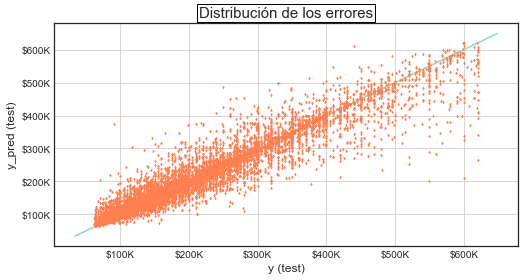

In [126]:
# Evaluamos el desempeño de los hiperparámetros encontrados por Random Search.
models = ['XGBoost optimizado randomsearch']

for i, model in enumerate([xgb_optimize_random]):
    y_train_pred_xgb_optimize_random = model.predict(x_train)
    y_test_pred_xgb_optimize_random = model.predict(x_test)
    
    print(f'Modelo: {models[i]}')
    
    r2_train= metrics.r2_score(y_train, y_train_pred_xgb_optimize_random)
    r2_test= metrics.r2_score(y_test, y_test_pred_xgb_optimize_random)
    

    RMSE_train=np.sqrt(mean_squared_error(y_train,y_train_pred_xgb_optimize_random))
    RMSE_test=np.sqrt(mean_squared_error(y_test,y_test_pred_xgb_optimize_random))

    print("R2 en Train:", r2_train)
    print("R2 en test:", r2_test)
    print("--------------------------")
    print("RMSE en train:",RMSE_train)
    print("RMSE en test:",RMSE_test)
    

    plt.figure(figsize = (14,4))
   
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred_xgb_optimize_random, s =2,c='coral', marker= 'd')
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min de ambos ejes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max de ambos ejes]
    ]
    
    ax.plot(lims, lims, 'k-',c='mediumaquamarine', alpha=0.75, zorder=0)
    plt.grid()
    plt.xlabel('y (test)',fontsize=12)
    plt.ylabel('y_pred (test)',fontsize=12)
    ax.yaxis.set_major_formatter(currency)
    ax.xaxis.set_major_formatter(currency)
    ax.set_title ('Distribución de los errores',
              fontsize=15,bbox={'facecolor':'1','pad':2})
    
    plt.tight_layout()
    plt.show()

#### Evaluación y conclusiones segundo modelo avanzado optimizado: **`XGBoost` + `Random Forest`**
* La distribución de los errores es, un 98% en el R2 en Train y un 91% en Test. Quedando en evidencia el sobreajuste en train. 
* En tanto y en cuanto al RMSE la ganancia es del **25%** vs nuestro modelo benchmarck **(43934 vs 33003).**
* Ergo, podemos afirmar que la optimización a través de `Random Search` no resulta como esperábamos. Al tener una grilla del espacio de búsqueda estática su resultado es inferior a los algoritmos avanzados sin optimizar, que exploran e iteran por más variables, obtenido mejores resultados.
* En el `Random Forest` la optimización corrige el sobre ajuste pero da un RMSE más alto que sin optimizar.
* Por su parte, el `XGBoost` mejora considerablemente el RMSE al optimizar, pero en el R2 en train hay "overfitting".

Antes de elegir nuestro modelo ganador vamos a optimizar nuestros modelos avanzados con otro método: `Optuna`. Buscamos validar de forma empírica nuestra conclusión sobre el `Random Search`.

---

## ¡Appendix 2! Nuevo método para optimizar hiperparámetros: **`Optuna`**

### Optimización `Random Forest` con el método `Optuna`

In [127]:
# Para eso definimos aquellos parámetros que queremos colocar, pero NO queremos mover luego.
FIXED_PARAMS_OP = {         
                'random_state': 42,           
                     }

In [128]:
# Defino el función objetivo
def clf_objective(trial):
    
    joblib.dump(study, 'study.pkl')
    
    clf_criterion = trial.suggest_categorical('criterion', ['mse', 'mae']) 
    clf_max_depth = trial.suggest_int('max_depth', 2, 50) 
    clf_min_samples_split = trial.suggest_int('min_samples_split', 20, 100) 
    clf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 50) 
    clf_max_features = trial.suggest_int('max_features', round(cant_columnas*0.1), round(cant_columnas*0.9)) 

    params = {
        'criterion': clf_criterion,
        'max_depth': clf_max_depth,
        'min_samples_split': clf_min_samples_split,
        'min_samples_leaf': clf_min_samples_leaf,
        'max_features': clf_max_features
    }
    
    clf.set_params(**FIXED_PARAMS_OP)
    clf.set_params(**params)
    # Ahora calculamos nuestros scores de test de un cross validation
    # Este objeto devuelve un array de todos los test_scores y tambien de los train_scores hallados --> nuestra loss será el promedio de los test_scores
    model_i_scores = cross_validate(clf, x_train, y_train.values.ravel(), cv=3, scoring=  make_scorer(eval_metrics), return_train_score=True)
    mean_test_scores = model_i_scores['test_score'].mean()
    # Pero también nos guardamos los promedios de train para poder ver si en general se estuvo overfitteando o no 
    mean_train_scores = model_i_scores['train_score'].mean()
    # Por último, resulta interesante ver cuan volatil fueron esos test_scores. Así que tomamos su desvio standard (std)
    std_test_scores = model_i_scores['test_score'].std()
    
    # Ahora guardamos estos datos en las listas vacias que creamos antes, así nos quedan bien guardados
    lista_test_scores_cv.append(mean_test_scores) # test
    lista_train_scores_cv.append(mean_train_scores) # train
    lista_test_std_cv.append(std_test_scores) # std de test
 
    # Definimos que la funcion de perdida sea el promedio de los scores de test
    loss = mean_test_scores

    return loss

In [129]:
sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='minimize',sampler=sampler)
study.optimize(clf_objective, n_trials=30,show_progress_bar=True)

[I 2021-07-25 10:42:23,218] A new study created in memory with name: no-name-ad870fee-98bc-4f04-8257-3a9f1533f09a
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2021-07-25 10:51:20,330] Trial 0 finished with value: 49436.284913230746 and parameters: {'criterion': 'mae', 'max_depth': 37, 'min_samples_split': 68, 'min_samples_leaf': 12, 'max_features': 2}. Best is trial 0 with value: 49436.284913230746.
[I 2021-07-25 11:17:57,703] Trial 1 finished with value: 47222.492991903004 and parameters: {'criterion': 'mae', 'max_depth': 31, 'min_samples_split': 77, 'min_samples_leaf': 5, 'max_features': 8}. Best is trial 1 with value: 47222.492991903004.
[I 2021-07-25 11:18:03,329] Trial 2 finished with value: 48394.53940099204 and parameters: {'criterion': 'mse', 'max_depth': 10, 'min_samples_split': 34, 'min_samples_leaf': 18, 'max_features': 5}. Best is trial 1 with value: 47222.492991903004.
[I 2021-07-25 11:18:08,138] Trial 3 finished with value: 46763.227934895665 and parameters: {'criterion': 'mse', 'max_depth': 31, 'min_samples_split': 31, 'min_samples_leaf': 18, 'max_features': 3}. Best is trial 3 with value: 46763.227934895665.
[I 2021-07-25 

In [130]:
# Armamos nuestro nuevo modelo con los mejores hiperparámetros + los parámetros fijos.
rf_optuna_best= study.best_params
rf_optuna_best.update(FIXED_PARAMS_OP)

In [131]:
# Colocamos esos mejores hiperparametros en nuestro modelo
clf_optuna = clf.set_params(**rf_optuna_best)

In [132]:
clf_optuna.fit(x_train,y_train.values.ravel())

RandomForestRegressor(max_depth=47, max_features=4, min_samples_leaf=8,
                      min_samples_split=39, n_estimators=66, random_state=42)

In [133]:
# Realizo las predicciones.
y_train_pred_clf_optuna = clf_optuna.predict(x_train)
y_test_pred_clf_optuna = clf_optuna.predict(x_test)

Modelo: Random Forest optimizado Optuna
R2 en Train: 0.8824441652409494
R2 en test: 0.8521091311120774
--------------------------
RMSE en train: 38385.97603273081
RMSE en test: 42381.66738153358


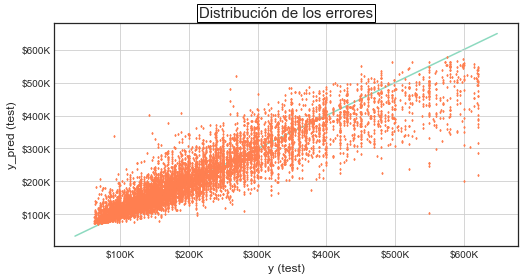

In [134]:
# Evaluamos el árbol optimizado con 'gp_minimize'.
models = ['Random Forest optimizado Optuna']

for i, model in enumerate([clf_optuna]):
    y_train_pred_clf_optuna = model.predict(x_train)
    y_test_pred_clf_optuna = model.predict(x_test)
    
    print(f'Modelo: {models[i]}')
    
    r2_train= metrics.r2_score(y_train, y_train_pred_clf_optuna)
    r2_test= metrics.r2_score(y_test, y_test_pred_clf_optuna)
    

    RMSE_train=np.sqrt(mean_squared_error(y_train,y_train_pred_clf_optuna))
    RMSE_test=np.sqrt(mean_squared_error(y_test,y_test_pred_clf_optuna))

    print("R2 en Train:", r2_train)
    print("R2 en test:", r2_test)
    print("--------------------------")
    print("RMSE en train:",RMSE_train)
    print("RMSE en test:",RMSE_test)
    

    plt.figure(figsize = (14,4))
   
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred_clf_optuna, s =2,c='coral', marker= 'd')
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min de ambos ejes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max de ambos ejes]
    ]
    
    ax.plot(lims, lims, 'k-',c='mediumaquamarine', alpha=0.75, zorder=0)
    plt.grid()
    plt.xlabel('y (test)',fontsize=12)
    plt.ylabel('y_pred (test)',fontsize=12)
    ax.yaxis.set_major_formatter(currency)
    ax.xaxis.set_major_formatter(currency)
    ax.set_title ('Distribución de los errores',
              fontsize=15,bbox={'facecolor':'1','pad':2})
    
    plt.tight_layout()
    plt.show()

### Evaluación y conclusiones modelo `Random Forest` optimizado con `Optuna`.

**¡Confirmamos nuestra hipótesis!** (Al menos con el `Random Forest`).
* `Optuna` resulto ser mejor optimizador que el `Randon Search`.
* Obtuvimos un RMSE que le gana a nuestro Benchmark en un 4% (43934 vs 42381).
* Este resultado se obtiene manteniendo la estabilidad del modelo con un R2 en Test del 91% y en Test del 87%.
* Tenemos un nuevo candidato...

Continuamos con nuestra muestra empírica y ahora vamos a optimizar nuestro modelo `XGBoost` con `Optuna`.

---

### Optimización `XGBoost` con el método `Optuna`.

In [135]:
def xgb_objective(trial):
    
    random_params = {
        'max_depth': trial.suggest_int('max_depth', 2, 50),
        'learning_rate': trial.suggest_uniform('learning_rate', 0, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0, 1.0),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'n_estimators': 100
    }
                                                        
    xgboost.set_params(**random_params)

    # Ahora calculamos nuestros scores de test de un cross validation
    # Este objeto devuelve un array de todos los test_scores y tambien de los train_scores hallados --> nuestra loss será el promedio de los test_scores
    model_i_scores = cross_validate(xgboost, x_train, y_train, cv=3, scoring=  make_scorer(eval_metrics), return_train_score=True)
    mean_test_scores = model_i_scores['test_score'].mean()
    # Pero también nos guardamos los promedios de train para poder ver si en general se estuvo overfitteando o no 
    mean_train_scores = model_i_scores['train_score'].mean()
    # Por último, resulta interesante ver cuan volatil fueron esos test_scores. Así que tomamos su desvio standard (std)
    std_test_scores = model_i_scores['test_score'].std()
    
    # Ahora guardamos estos datos en las listas vacias que creamos antes, así nos quedan bien guardados
    lista_test_scores_cv.append(mean_test_scores) # test
    lista_train_scores_cv.append(mean_train_scores) # train
    lista_test_std_cv.append(std_test_scores) # std de test
 
    # Definimos que la funcion de perdida sea el promedio de los scores de test
    loss = mean_test_scores

    return loss

In [136]:
study = optuna.create_study(direction='minimize',sampler=sampler)
study.optimize(xgb_objective, n_trials=30,show_progress_bar=True)

[I 2021-07-25 12:20:05,042] A new study created in memory with name: no-name-b00cbadb-25a7-4e64-aa14-594044dd2a96
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2021-07-25 12:20:11,561] Trial 0 finished with value: 39306.431801639876 and parameters: {'max_depth': 21, 'learning_rate': 0.2713490317738959, 'subsample': 0.8287375091519293, 'colsample_bytree': 0.3567533266935893, 'eta': 0.09147100780934041}. Best is trial 0 with value: 39306.431801639876.
[I 2021-07-25 12:20:19,236] Trial 1 finished with value: 52046.81082497739 and parameters: {'max_depth': 28, 'learning_rate': 0.14092422497476265, 'subsample': 0.8021969807540397, 'colsample_bytree': 0.07455064367977082, 'eta': 0.29619721161415}. Best is trial 0 with value: 39306.431801639876.
[I 2021-07-25 12:20:23,889] Trial 2 finished with value: 67702.60450400492 and parameters: {'max_depth': 39, 'learning_rate': 0.1987156815341724, 'subsample': 0.005522117123602399, 'colsample_bytree': 0.8154614284548342, 'eta': 0.21498862971580895}. Best is trial 0 with value: 39306.431801639876.
[I 2021-07-25 12:20:28,191] Trial 3 finished with value: 176567.52147547892 and parameters: {'max_depth': 37, 

In [137]:
# Armamos nuestro nuevo modelo con los mejores hiperparámetros + los parámetros fijos.
xgb_optuna_best= study.best_params
xgb_optuna_best.update(FIXED_PARAMS_OP)
xgb_optuna_best

{'max_depth': 30,
 'learning_rate': 0.08788454028709847,
 'subsample': 0.577421409801413,
 'colsample_bytree': 0.7842380168362497,
 'eta': 0.16731328056360548,
 'random_state': 42}

In [138]:
# Colocamos esos mejores hiperparametros en nuestro modelo
xgb_optuna = xgboost.set_params(**xgb_optuna_best)

In [139]:
xgb_optuna.fit(x_train,y_train.values.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=0.7842380168362497,
             eta=0.16731328056360548, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08788454028709847, max_delta_step=0, max_depth=30,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.577421409801413, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [140]:
# Realizo las predicciones.
y_train_pred_xgb_optuna = xgb_optuna.predict(x_train)
y_test_pred_xgb_optuna = xgb_optuna.predict(x_test)

Modelo: XGBoost optimizado Optuna
R2 en Train: 0.992786346717342
R2 en test: 0.9118640916617823
--------------------------
RMSE en train: 9508.852816743256
RMSE en test: 32717.77797016047


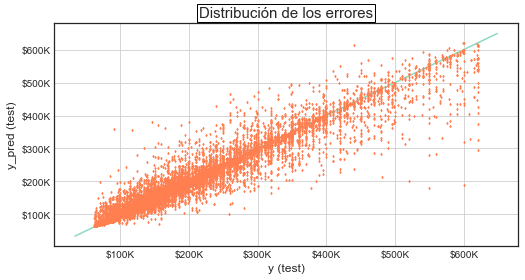

In [141]:
# Evaluamos el árbol optimizado con 'gp_minimize'.
models = ['XGBoost optimizado Optuna']

for i, model in enumerate([xgb_optuna]):
    y_train_pred_xgb_optuna = model.predict(x_train)
    y_test_pred_xgb_optuna = model.predict(x_test)
    
    print(f'Modelo: {models[i]}')
    
    r2_train= metrics.r2_score(y_train, y_train_pred_xgb_optuna)
    r2_test= metrics.r2_score(y_test, y_test_pred_xgb_optuna)
    

    RMSE_train=np.sqrt(mean_squared_error(y_train,y_train_pred_xgb_optuna))
    RMSE_test=np.sqrt(mean_squared_error(y_test,y_test_pred_xgb_optuna))

    print("R2 en Train:", r2_train)
    print("R2 en test:", r2_test)
    print("--------------------------")
    print("RMSE en train:",RMSE_train)
    print("RMSE en test:",RMSE_test)
    

    plt.figure(figsize = (14,4))
   
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred_xgb_optuna, s =2,c='coral', marker= 'd')
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min de ambos ejes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max de ambos ejes]
    ]
    
    ax.plot(lims, lims, 'k-',c='mediumaquamarine', alpha=0.75, zorder=0)
    plt.grid()
    plt.xlabel('y (test)',fontsize=12)
    plt.ylabel('y_pred (test)',fontsize=12)
    ax.yaxis.set_major_formatter(currency)
    ax.xaxis.set_major_formatter(currency)
    ax.set_title ('Distribución de los errores',
              fontsize=15,bbox={'facecolor':'1','pad':2})
    
    plt.tight_layout()
    plt.show()

### Evaluación y conclusiones modelo `XGBoost` optimizado con `Optuna`.

* Para nuestra sorpresa el `Optuna` no logra corregir los problemas que tuvimos con la optimización del `Random Search`.
* El resultado es muy similar con una ganancia ostensible en el RMSE vs el Benchmark (43934 vs 32717) pero con un sobre ajuste en Train lo que lo transforma en un modelo inestable.
* Visto y considerando todo lo explorado podemos definir al gran ganador.

**Nuestro modelo ganador es:  `Random Forest` optimizado con `Optuna`** (aplausos).

* Como vimos mejora el RMSE en un 10% vs el Benchmark y un 73% respecto al modelo del Sprint proyect 1. 
* Además, es un modelo estable con un R2 en train del 91% y en Test del 87%.
---

## Explicador de  modelos: `Shap`
### 1. Modelo Benchmark.

In [142]:
# Utilizamos el explicador de SHAP.
explainer_benchmark = shap.TreeExplainer(tree)
# Otorgamos los valores de importancia que tendrá en el dataframe de validación.
shap_values_benchmark = explainer_benchmark.shap_values(x_test)

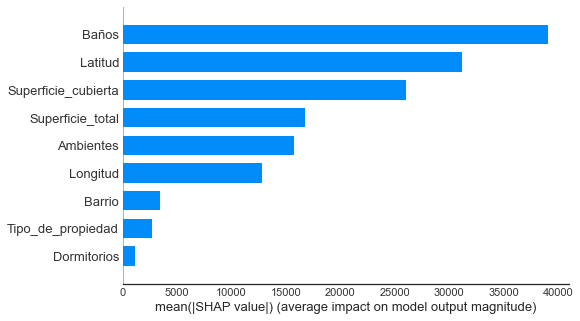

In [143]:
# Graficamos solo la importancia de cada variable.
shap.summary_plot(shap_values_benchmark, x_test, plot_type="bar")

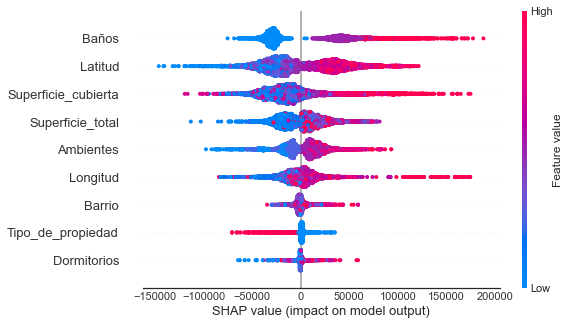

In [144]:
# Graficamos el impacto de cada variable.
shap.summary_plot(shap_values_benchmark, x_test)

### 2. Modelo "ganador".

In [145]:
# Volvemos a utilizar el explicador de SHAP, pero ahora para nuestro modelo "ganador".
explainer_randomforest = shap.TreeExplainer(clf_optuna)
# Otorgamos los valores de importancia que tendrá en el dataframe de validación
shap_values_randomforest = explainer_randomforest.shap_values(x_test)

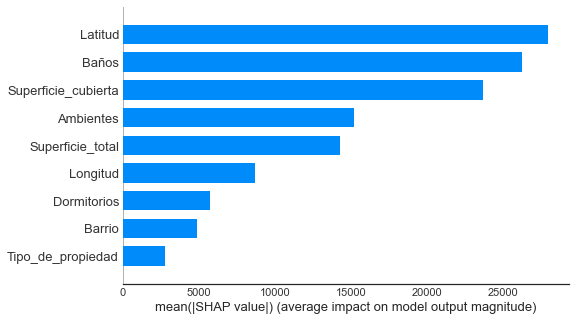

In [146]:
# Graficamos solo la importancia de cada variable.
shap.summary_plot(shap_values_randomforest, x_test, plot_type="bar")

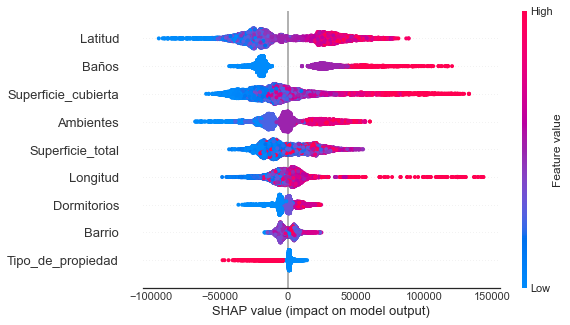

In [147]:
# Graficamos el impacto de cada variable.
shap.summary_plot(shap_values_randomforest, x_test)

## Interpretación modelo "ganador".

In [148]:
# Alistamos nuetras prediciones para concatenarlas con nuestro dataset de testeo.
precio_pred= pd.DataFrame ({'Precio_pred_clf_optuna':y_test_pred_clf_optuna.copy()}) 
# La sumamos al dataset de testeo.
error_modelo_bm['Precio_pred_clf_optuna']=precio_pred 
# Por último creamos una columana con las diferencias.
error_modelo_bm['Error_modelwin']= round (error_modelo_bm.Precio - error_modelo_bm.Precio_pred_clf_optuna) 
error_modelo_bm = error_modelo_bm.sort_values('Error_modelwin',ascending=False)
error_modelo_bm

,Latitud,Longitud,Barrio,Ambientes,Dormitorios,Baños,Superficie_total,Superficie_cubierta,Tipo_de_propiedad,Precio,Precio_pred,Error,Precio_pred_clf_optuna,Error_modelwin
2565,-34.603815,-58.434263,Parque Centenario,1.0,0.0,2.0,218.82,113.37,Casa,550000.0,92983.160714,457017.0,103948.711589,446051.0
11649,-34.651721,-58.476588,Parque Avellaneda,7.0,6.0,2.0,218.82,113.37,Casa,620000.0,160000.000000,460000.0,220188.763598,399811.0
1752,-34.628714,-58.413872,Boedo,4.0,3.0,1.0,218.82,113.37,Departamento,600000.0,157000.000000,443000.0,200345.773033,399654.0
6476,-34.573381,-58.421691,Palermo,3.0,2.0,2.0,218.82,113.37,Departamento,620000.0,560000.000000,60000.0,284956.724581,335043.0
4084,-34.640506,-58.378987,Barracas,4.0,3.0,2.0,270.00,240.00,Departamento,609000.0,280000.000000,329000.0,304115.867729,304884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,-34.623966,-58.370135,San Telmo,7.0,5.0,3.0,175.00,160.00,Departamento,189000.0,380000.000000,-191000.0,408887.989202,-219888.0
10583,-34.621378,-58.434042,Caballito,8.0,3.0,3.0,375.00,225.00,Casa,260000.0,280000.000000,-20000.0,481802.843665,-221803.0
1516,-34.562084,-58.456686,Belgrano,3.0,2.0,2.0,116.00,68.00,Departamento,90400.0,336103.870968,-245704.0,337249.636044,-246850.0
7725,-34.585047,-58.452225,Chacarita,5.0,3.0,3.0,306.00,227.00,Casa,269000.0,550000.000000,-281000.0,518693.109722,-249693.0


* Al igual que con nuestro modelo benchmarck el **TOP 3 de los errores más grandes corresponden a instancias donde se manipularon los datos e intentamos recuperar datos perdidos.**
* Oportunidad para una nueva iteración, eliminar los missing que no sean considerables en volumen.
* También podemos observar como mejora el error en nuestro modelo “ganador”, ganando un 3% al compararlo con el modelo benchmark (446051 vs. 460000).
* Resultan son los mismos datos los que conforman el TOP 3 en ambos modelos, dejando en evidencia que ambos casos “les cuesta” predecir sobre los barrios menos frecuentes.

In [149]:
# Agrupamos el dataset de testo por el error promedio por Barrio para nuesro modelo "ganador".
group_barrio_modelwin_mean = error_modelo_bm.groupby('Barrio', as_index= False).agg({'Error_modelwin' :'mean'})
group_barrio_modelwin_mean  = group_barrio_modelwin_mean.sort_values('Error_modelwin',ascending=False)
group_barrio_modelwin_mean.tail(3)

,Barrio,Error_modelwin
51,Villa Riachuelo,-32386.000000
53,Villa Soldati,-41933.000000
7,Boca,-56237.155556


* Los barrios donde mayor error encontramos son: La Boca, Villa Soldati y Villa Riachuelo.

In [150]:
model_aciertos = (error_modelo_bm[(error_modelo_bm.Error_modelwin <= 10)])
model_aciertos_agrupados = model_aciertos.groupby('Barrio', as_index= False).agg({'Error_modelwin' :'count'})
model_aciertos_agrupados = model_aciertos_agrupados.sort_values('Error_modelwin',ascending=False)
model_aciertos_agrupados.head(3)

,Barrio,Error_modelwin
25,Palermo,875
2,Almagro,535
43,Villa Crespo,503


* Si bien los Barrios donde logramos mejor resultado son los mismos (Palermo, Almagro y Villa Crespo) que en nuestro modelo benchmark, podemos observar que la exactitud es otra.
* ¿Por qué decimos esto? Al filtrar por "Error_modelwin" igual cero, descubrimos que no tenemos ninguna predicción que acierte al valor del precio exacto. Para encontrar los barrios donde menor error tuvimos que hacerlo por "igual o menor a 10" y ahí si obtuvimos el resultado deseado.

In [151]:
# Agrupamos el error promedio por Tipo de propiedad para nuesro modelo benchmark..
group_propiedad_modelwin_mean = error_modelo_bm.groupby('Tipo_de_propiedad', as_index= False).agg({'Error_modelwin' :'mean'})
group_propiedad_modelwin_mean = group_propiedad_modelwin_mean.sort_values('Error_modelwin',ascending=True)
group_propiedad_modelwin_mean

,Tipo_de_propiedad,Error_modelwin
2,PH,-7485.277379
1,Departamento,713.704310
0,Casa,7086.028571


* Por último y solo para completar el análisis, vamos que Departamento es el Tipo de Propiedad donde logramos mejor resultado.
---

## Cierre

* La importancia y el impacto de cada variable es similar en ambos modelos. Esto se debe a que nuestro modelo de ensamble se soporta y alimenta de nuestro modelo simple.
* Las mejoras en los resultados entre uno y el otro no radica en las variables sino en la robustez de cada modelo. Mientras que en el modelo simple solo ajustamos la profundidad en nuestro modelo de ensamble los parámetros que se ajustaron eran múltiples.
* Adicional a esto podemos decir, si en el preprosesamiento eliminamos los datos perdidos para las Superficies (una de las variables que más peso tiene en el modelo) en lugar de manipularlos e imputar el promedio del conjunto de la variable podríamos tener menor error. Recordemos que como vimos los Barrios donde más alejados nos encontramos del precio fueron en todos los casos donde recuperamos estos datos.
* Dependiendo la necesidad, incluso si nos enfocamos en los Departamentos y filtramos los 20 barrios con más instancias también podemos obtener mejores resultados. Pero es claro que ahí vamos a depender de lo que se espere, podemos ganar mejorando nuestros modelos, pero dejamos de lado parte importante de los datos que se requerían también predecir.
* Como recomendación final, pediríamos mejorar la captación y calidad para Casa y PH, como así también en lo posible aumentar el volumen de datos de los Barrios donde menos instancias tenemos.
---

In [152]:
# Vemos finalmente cuanto tiempo le tomo ejecutar todo el código.
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 2:08:49.070682
